# 제품 이상여부 판별 프로젝트

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
from pprint import pprint

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [8]:
# RANDOM_STATE = 110

# train_data = pd.read_csv("../../data/train.csv")
# test_data = pd.read_csv("../../data/test.csv")

### 0. 결측값 처리

밀린행 처리

In [9]:
# def shift_row_values(row, start_col_index, move_limit, total_columns):
#     move_count = 0  # 이동 카운터 초기화
#     for col_index in range(start_col_index, total_columns):  # 모든 열을 대상으로
#         if pd.isna(row[col_index]) or row[col_index] == "OK":  # 빈값 또는 "OK" 확인
#             # 빈값 또는 "OK"가 발견되면 현재 위치부터 이후 3칸 간격의 변수 값을 앞으로 이동
#             for shift_index in range(col_index, total_columns - 3, 3):  # 3칸씩 이동
#                 # 값을 이동
#                 row[shift_index] = row[shift_index + 3]
#                 row[shift_index + 3] = None  # 원래 자리 비우기
#                 move_count += 1  # 이동 카운트 증가

#                 if move_count >= move_limit:  # 설정된 횟수에 도달하면 중지
#                     break
#         if move_count >= move_limit:  # 외부 루프에서도 체크
#             break
#     return row

# def shift_values(data, start_col_index, move_limit):
#     total_columns = data.shape[1]
#     data = data.apply(shift_row_values, axis=1, args=(start_col_index, move_limit, total_columns))
#     return data

# # 변수 이름 설정 및 시작 열 인덱스 및 이동 횟수 설정
# variables_with_limits = [
#     ('HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam', 52),
#     ('HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 22),
#     ('HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2', 22)
# ]

# # 각 변수에 대해 함수 호출
# def process_data(data, variables_with_limits, output_file):
#     for start_var, move_limit in variables_with_limits:
#         start_col_index = data.columns.get_loc(start_var)  # 각 변수의 시작 열 인덱스 찾기
#         data = shift_values(data, start_col_index, move_limit)
#     data.to_csv(output_file, index=False)
#     print(f'데이터가 성공적으로 수정되고 저장되었습니다: {output_file}')

# # 데이터 처리
# process_data(train_data, variables_with_limits, '../../data/clean_train.csv')
# process_data(test_data, variables_with_limits, '../../data/clean_test.csv')

In [10]:
# csv 불러오기
train_data = pd.read_csv('../../final_data/clean_final_train.csv')
test_data = pd.read_csv('../../final_data/clean_final_train.csv')
plus_data = pd.read_excel('../../final_data/hand_data.xlsx')


반복적으로 쓰는 툴 함수화

In [11]:
def plot_box(df, col_name):
    """
    주어진 데이터프레임과 열 이름에 대해 박스 플롯을 그리는 함수.

    Parameters:
    dataframe (pd.DataFrame): 데이터프레임
    column_name (str): 열 이름
    """
    plt.figure(figsize=(7, 4))
    plt.boxplot(df[col_name], vert=False)
    plt.xlabel(col_name)
    plt.title(f'Box Plot of {col_name}')
    plt.show()

def value_counts_ratio(df, col_name, target_name='target'):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 비율과 갯수, 총 갯수를 출력하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    """
    # 각 값마다 타겟 변수의 비율 계산
    value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
    
    # 각 값마다 타겟 변수의 갯수 계산
    counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)
    
    # 각 값마다 총 갯수 계산
    total_counts = df[col_name].value_counts().rename('Total_Count')
    
    # 비율과 갯수를 합침
    result = value_counts.join(counts, lsuffix='_ratio', rsuffix='_count')
    
    # 총 갯수를 합침
    result = result.join(total_counts, on=col_name)
    
    # 출력 형식 조정
    result.index.name = 'variable'
    print(f"\n{col_name}별 {target_name} 비율 및 갯수\n")
    print(result.rename(columns=lambda x: x.split('_')[0]))

def summarize_group(df, group_by_columns):
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_columns)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # 'target' 변수의 'AdNormal' 비율과 갯수 계산
        adnormal_count = group['target'].value_counts().get('AbNormal', 0)
        adnormal_ratio = adnormal_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, adnormal_count, adnormal_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', "'AdNormal' count", 'ratio', 'Total'])
    
    # 그룹화된 변수들의 이름을 제목행으로 출력
    print(f"Grouped by: {', '.join(group_by_columns)}")
    print()
    # 데이터프레임 출력
    print(results_df)

# 예시코드
# summarize_grouped_data(train_data, ['1st Pressure Collect Result_AutoClave', '1st Pressure Unit Time_AutoClave'])

def plot_ratio(df, group_by_column, target_column='target', abnormal_value='AbNormal'):
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_column)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # 'target' 변수의 'AbNormal' 비율과 갯수 계산
        abnormal_count = group[target_column].value_counts().get(abnormal_value, 0)
        abnormal_ratio = abnormal_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, abnormal_count, abnormal_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', f"'{abnormal_value}' count", 'ratio', 'Total'])
    
    # 그래프 크기 설정
    plt.figure(figsize=(10, 5))
    
    # 막대 그래프 생성
    ax = results_df.plot(kind='bar', x='group', y='ratio', legend=False)
    
    # 각 막대 위에 AbNormal 갯수와 총 갯수 표시
    for i, (abnormal_count, total) in enumerate(zip(results_df[f"'{abnormal_value}' count"], results_df['Total'])):
        ax.text(i, results_df['ratio'][i], f'{abnormal_count} ({total})', ha='center', va='bottom', fontsize=8)
    
     # 그래프 제목 및 축 레이블 설정
    ax.set_title(f'{abnormal_value} Ratio by {group_by_column}')
    ax.set_xlabel(group_by_column)
    ax.set_ylabel(f'{abnormal_value} Ratio')
   
    # 그래프 출력
    plt.show()

def plot_ratio_boxplot(data, time_ratio_column, target_column='target'):
    # 그래프 스타일 설정
    sns.set(style="whitegrid")

    # 그래프 그리기
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=time_ratio_column, y=target_column, data=data)

    # 그래프 제목 및 레이블 설정
    plt.title(f'{time_ratio_column} vs {target_column}')
    plt.xlabel(time_ratio_column)
    plt.ylabel(target_column)

    # 그래프 출력
    plt.show()

# 함수 호출 예제
#plot_ratio_boxplot(train_data, 'time_ratio_Dam')

In [12]:
plus_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 15 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   day                                       105 non-null    int64  
 1   start_time                                105 non-null    object 
 2   end_time                                  105 non-null    object 
 3   Dam Thickness - 1time / day               81 non-null     float64
 4   Fill thickness - 1time / day              81 non-null     float64
 5   Fill cure energy (mJ) - Every break time  81 non-null     float64
 6   Fill cure power (mW) - Every break time   81 non-null     float64
 7   Line Temp. - Every break time             81 non-null     float64
 8   Line humidity - Every break time          81 non-null     float64
 9   OCR gap - Line#1 stage1                   81 non-null     float64
 10  OCR gap - Line#1 stage2               

In [18]:
train_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 468 columns):
 #    Column                                                      Dtype  
---   ------                                                      -----  
 0    Wip Line_Dam                                                object 
 1    Process Desc._Dam                                           object 
 2    Equipment_Dam                                               object 
 3    Model.Suffix_Dam                                            object 
 4    Workorder_Dam                                               object 
 5    Collect Date_Dam                                            object 
 6    Insp. Seq No._Dam                                           int64  
 7    Insp Judge Code_Dam                                         object 
 8    CURE END POSITION X Collect Result_Dam                      float64
 9    CURE END POSITION X Unit Time_Dam                           float64
 1

In [23]:
train_data['Chamber Temp. Collect Result_AutoClave'].value_counts()

54    8427
49    5836
50    5652
53    5342
48    3347
55    3282
52    2081
47    1787
56    1699
51    1478
57     951
46     376
58     102
45      37
36      33
32      23
43      20
37       6
38       6
59       4
33       4
35       4
44       3
40       3
34       2
42       1
Name: Chamber Temp. Collect Result_AutoClave, dtype: int64

In [31]:
import pandas as pd

# 'day'와 'start_time' 변수의 조합 갯수 세기
combination_counts = plus_data.groupby(['day', 'start_time', 'end_time']).size().reset_index(name='counts')

# 결과 확인
print(combination_counts)

        day start_time  end_time  counts
0    240319   08:00:00  10:30:00       1
1    240319   10:45:00  12:00:00       1
2    240319   13:00:00  15:00:00       1
3    240319   15:15:00  18:00:00       1
4    240319   18:30:00  20:00:00       1
..      ...        ...       ...     ...
100  240428   08:00:00  10:30:00       1
101  240428   10:45:00  12:00:00       1
102  240428   13:00:00  15:00:00       1
103  240428   15:15:00  18:00:00       1
104  240428   18:30:00  20:00:00       1

[105 rows x 4 columns]


### 1. 기본 전처리

In [207]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 468 entries, Wip Line_Dam to target
dtypes: float64(362), int64(68), object(38)
memory usage: 144.6+ MB


모든 값이 NaN인 열 제거

In [208]:
# target 열을 임시로 분리
target_train = train_data['target']
target_test = test_data['target']

# 모든 값이 NaN인 열 제거
train_data = train_data.dropna(axis=1, how='all')
test_data = test_data.dropna(axis=1, how='all')

# target 열을 다시 결합
train_data['target'] = target_train
test_data['target'] = target_test

In [209]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 190 entries, Wip Line_Dam to target
dtypes: float64(84), int64(68), object(38)
memory usage: 58.7+ MB


In [210]:
# 'Process Desc'를 포함하는 열 이름 필터링
filter_col = train_data.filter(like='Collect Date_').columns

print("< Process Desc 포함 변수 >")
for col in filter_col:
    print(col)

< Process Desc 포함 변수 >
Collect Date_Dam
Collect Date_AutoClave
Collect Date_Fill1
Collect Date_Fill2


In [211]:
import pandas as pd

# Collect Date 열들을 datetime 형식으로 변환
train_data['Collect Date_Dam'] = pd.to_datetime(train_data['Collect Date_Dam'])
train_data['Collect Date_Fill1'] = pd.to_datetime(train_data['Collect Date_Fill1'])
train_data['Collect Date_Fill2'] = pd.to_datetime(train_data['Collect Date_Fill2'])
train_data['Collect Date_AutoClave'] = pd.to_datetime(train_data['Collect Date_AutoClave'])

# 각 열 간의 시간 차이를 계산하여 새로운 변수 생성
train_data['time_diff_Dam_Fill1'] = (train_data['Collect Date_Fill1'] - train_data['Collect Date_Dam']).dt.total_seconds() / 60
train_data['time_diff_Fill1_Fill2'] = (train_data['Collect Date_Fill2'] - train_data['Collect Date_Fill1']).dt.total_seconds() / 60
train_data['time_diff_Fill2_AutoClave'] = (train_data['Collect Date_AutoClave'] - train_data['Collect Date_Fill2']).dt.total_seconds() / 60
train_data['time_diff_Dam_AutoClave'] = (train_data['Collect Date_AutoClave'] - train_data['Collect Date_Dam']).dt.total_seconds() / 60 

# 결과 확인
print(train_data[['time_diff_Dam_Fill1'
                  , 'time_diff_Fill1_Fill2'
                  , 'time_diff_Fill2_AutoClave'
                  ,'time_diff_Dam_AutoClave']].head())

   time_diff_Dam_Fill1  time_diff_Fill1_Fill2  time_diff_Fill2_AutoClave  \
0                 10.0                    0.0                       30.0   
1                  0.0                    0.0                       30.0   
2                  0.0                    0.0                       40.0   
3                  0.0                    0.0                       40.0   
4                  0.0                    0.0                       40.0   

   time_diff_Dam_AutoClave  
0                     40.0  
1                     30.0  
2                     40.0  
3                     40.0  
4                     40.0  


<Figure size 1000x500 with 0 Axes>

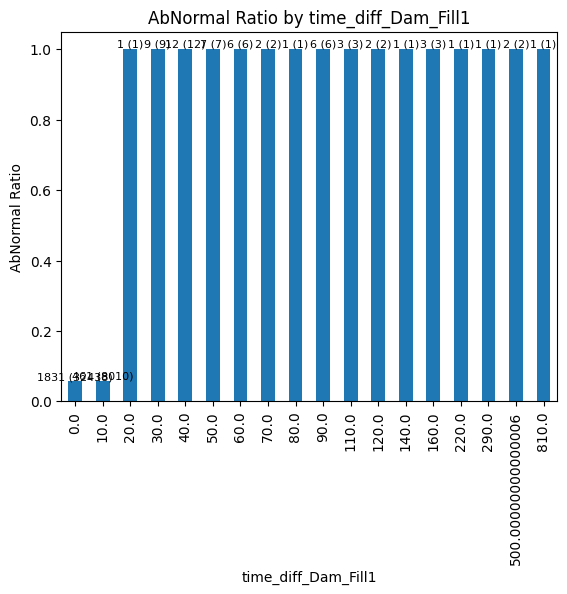

In [212]:
plot_ratio(train_data, 'time_diff_Dam_Fill1')

<Figure size 1000x500 with 0 Axes>

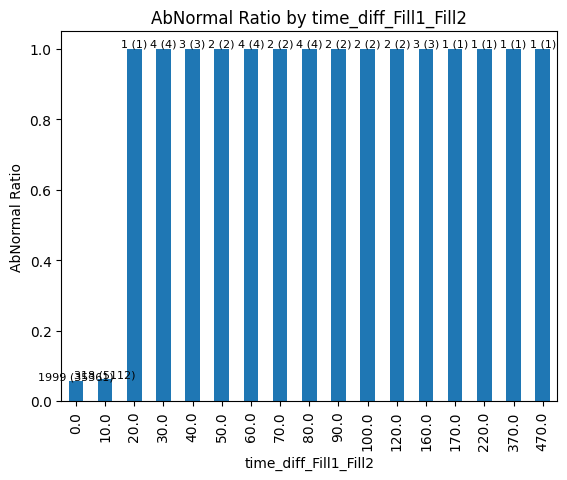

In [213]:
plot_ratio(train_data, 'time_diff_Fill1_Fill2')

<Figure size 1000x500 with 0 Axes>

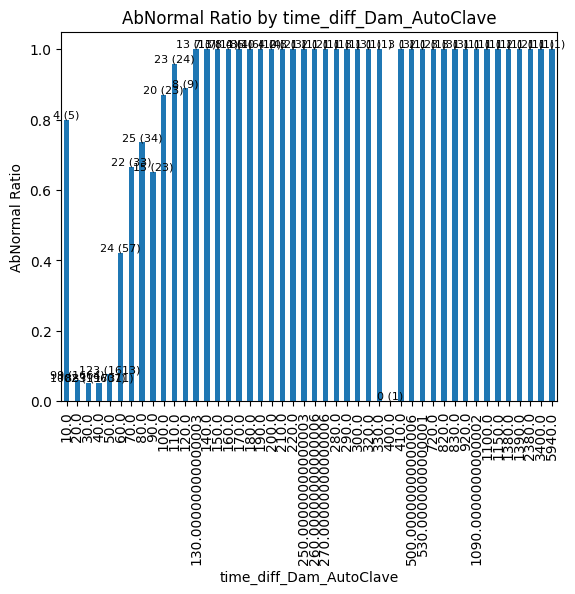

In [215]:
plot_ratio(train_data, 'time_diff_Dam_AutoClave')

<Figure size 1000x500 with 0 Axes>

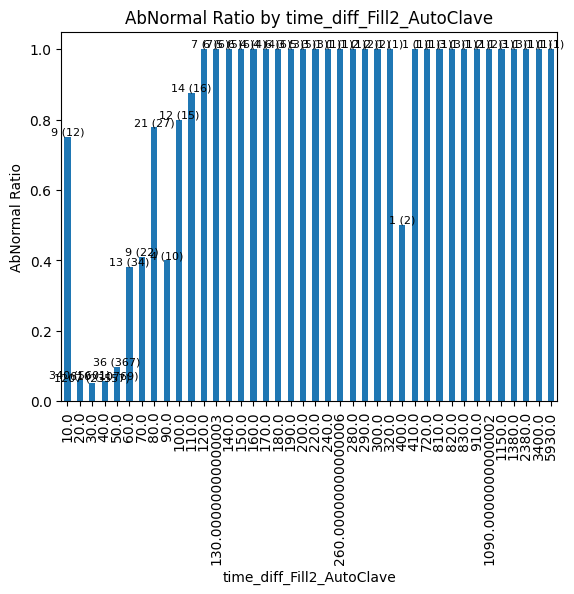

In [216]:
plot_ratio(train_data, 'time_diff_Fill2_AutoClave')

In [195]:
summarize_group(train_data, ['time_diff_Dam_Fill1', 'time_diff_Fill1_Fill2'])

Grouped by: time_diff_Dam_Fill1, time_diff_Fill1_Fill2

                        group  'AdNormal' count     ratio  Total
0                  (0.0, 0.0)              1497  0.054813  27311
1                 (0.0, 10.0)               310  0.060749   5103
2                 (0.0, 30.0)                 3  1.000000      3
3                 (0.0, 40.0)                 3  1.000000      3
4                 (0.0, 50.0)                 2  1.000000      2
5                 (0.0, 60.0)                 2  1.000000      2
6                 (0.0, 70.0)                 1  1.000000      1
7                 (0.0, 80.0)                 4  1.000000      4
8                 (0.0, 90.0)                 2  1.000000      2
9                (0.0, 100.0)                 1  1.000000      1
10               (0.0, 120.0)                 1  1.000000      1
11               (0.0, 160.0)                 3  1.000000      3
12               (0.0, 170.0)                 1  1.000000      1
13               (0.0, 470.0)     

In [196]:
import pandas as pd

# 조건에 맞는 조합을 확인하는 함수
def check_combination(row):
    valid_combinations = [(0.0, 0.0), (0.0, 10.0), (10.0, 0.0), (10.0, 10.0)]
    if (row['time_diff_Dam_Fill1'], row['time_diff_Fill1_Fill2']) in valid_combinations:
        return 0
    else:
        return 1

# 파생 변수 생성
train_data['combination_flag'] = train_data.apply(check_combination, axis=1)

# 결과 확인
print(train_data[['time_diff_Dam_Fill1', 'time_diff_Fill1_Fill2', 'combination_flag']].head())

   time_diff_Dam_Fill1  time_diff_Fill1_Fill2  combination_flag
0                 10.0                    0.0                 0
1                  0.0                    0.0                 0
2                  0.0                    0.0                 0
3                  0.0                    0.0                 0
4                  0.0                    0.0                 0


In [197]:
# 파생변수 생성
train_data['time_diff_flag'] = train_data['time_diff_Dam_AutoClave'].apply(lambda x: 1 if x >= 130 else 0)

In [198]:
summarize_group(train_data, ['time_diff_flag', 'combination_flag'])

Grouped by: time_diff_flag, combination_flag

    group  'AdNormal' count     ratio  Total
0  (0, 0)              2187  0.054211  40342
1  (0, 1)                61  1.000000     61
2  (1, 0)                73  0.986486     74
3  (1, 1)                29  1.000000     29


In [199]:
value_counts_ratio(train_data, 'combination_flag')


combination_flag별 target 비율 및 갯수

          AbNormal    Normal  AbNormal   Normal  Total
variable                                              
0         0.055918  0.944082    2260.0  38156.0  40416
1         1.000000  0.000000      90.0      0.0     90


In [200]:
import pandas as pd

# 조건에 맞는 조합을 확인하는 함수
def assign_flag(row):
    if (row['time_diff_flag'], row['combination_flag']) == (0, 0):
        return 0
    else:
        return 1

# 파생 변수 생성
train_data['gap_time_total'] = train_data.apply(assign_flag, axis=1)

# 결과 확인
print(train_data[['time_diff_flag', 'combination_flag', 'gap_time_total']].head())

   time_diff_flag  combination_flag  gap_time_total
0               0                 0               0
1               0                 0               0
2               0                 0               0
3               0                 0               0
4               0                 0               0


<Figure size 1000x500 with 0 Axes>

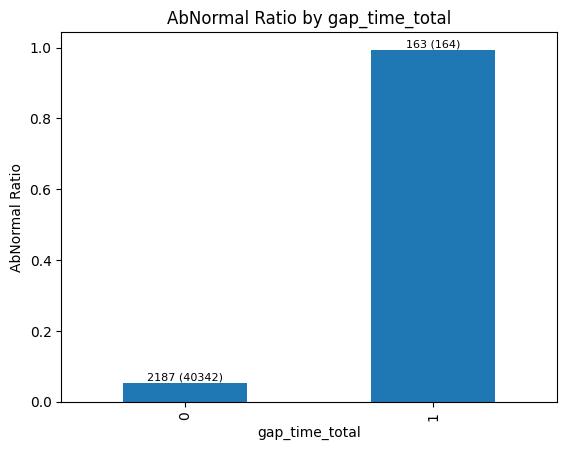

In [201]:
plot_ratio(train_data, 'gap_time_total')

<Figure size 1000x500 with 0 Axes>

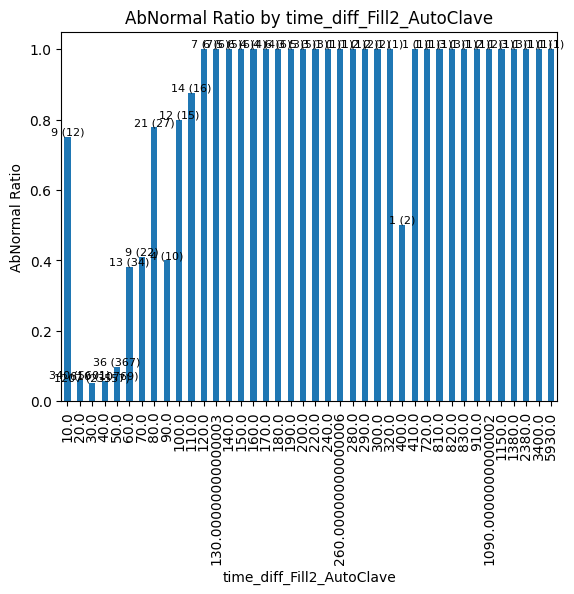

In [161]:
plot_ratio(train_data, 'time_diff_Fill2_AutoClave')

<Figure size 1000x500 with 0 Axes>

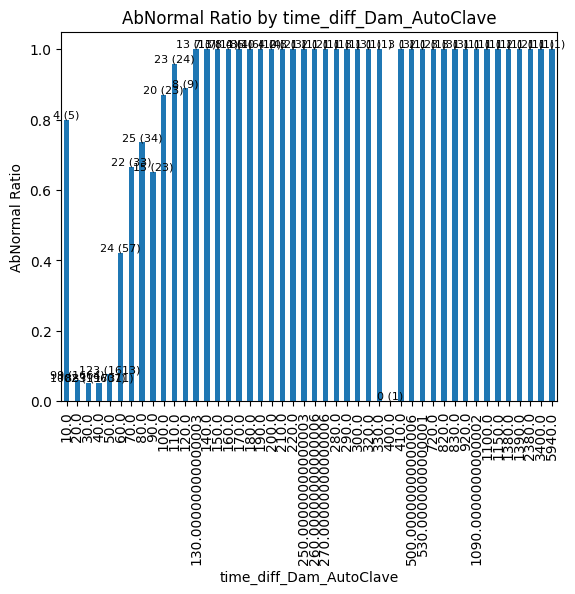

In [162]:
plot_ratio(train_data, 'time_diff_Dam_AutoClave')

In [134]:
import pandas as pd

# pandas 출력 설정 변경
pd.set_option('display.max_columns', None)  # 모든 열 출력
pd.set_option('display.max_rows', None)     # 모든 행 출력

# summarize_group 함수 호출
summarize_group(train_data, ['time_diff_Dam_Fill1', 'time_diff_Fill2_AutoClave'])

Grouped by: time_diff_Dam_Fill1, time_diff_Fill2_AutoClave

                         group  'AdNormal' count     ratio  Total
0                  (0.0, 10.0)                 6  0.750000      8
1                  (0.0, 20.0)               209  0.058790   3555
2                  (0.0, 30.0)               937  0.050420  18584
3                  (0.0, 40.0)               529  0.054123   9774
4                  (0.0, 50.0)                30  0.084986    353
5                  (0.0, 60.0)                11  0.379310     29
6                  (0.0, 70.0)                 6  0.375000     16
7                  (0.0, 80.0)                14  0.736842     19
8                  (0.0, 90.0)                 4  0.400000     10
9                 (0.0, 100.0)                11  0.785714     14
10                (0.0, 110.0)                12  0.923077     13
11                (0.0, 120.0)                 4  1.000000      4
12   (0.0, 130.00000000000003)                 6  1.000000      6
13              

In [133]:
summarize_group(train_data,['time_diff_Dam_Fill1', 'time_diff_Fill2_AutoClave'])

Grouped by: time_diff_Dam_Fill1, time_diff_Fill2_AutoClave

                         group  'AdNormal' count     ratio  Total
0                  (0.0, 10.0)                 6  0.750000      8
1                  (0.0, 20.0)               209  0.058790   3555
2                  (0.0, 30.0)               937  0.050420  18584
3                  (0.0, 40.0)               529  0.054123   9774
4                  (0.0, 50.0)                30  0.084986    353
5                  (0.0, 60.0)                11  0.379310     29
6                  (0.0, 70.0)                 6  0.375000     16
7                  (0.0, 80.0)                14  0.736842     19
8                  (0.0, 90.0)                 4  0.400000     10
9                 (0.0, 100.0)                11  0.785714     14
10                (0.0, 110.0)                12  0.923077     13
11                (0.0, 120.0)                 4  1.000000      4
12   (0.0, 130.00000000000003)                 6  1.000000      6
13              

In [117]:
summarize_group(train_data,['time_diff_Dam_Fill1', 'time_diff_Fill1_Fill2'])

Grouped by: time_diff_Dam_Fill1, time_diff_Fill1_Fill2

                        group  'AdNormal' count     ratio  Total
0                  (0.0, 0.0)              1497  0.054813  27311
1                 (0.0, 10.0)               310  0.060749   5103
2                 (0.0, 30.0)                 3  1.000000      3
3                 (0.0, 40.0)                 3  1.000000      3
4                 (0.0, 50.0)                 2  1.000000      2
5                 (0.0, 60.0)                 2  1.000000      2
6                 (0.0, 70.0)                 1  1.000000      1
7                 (0.0, 80.0)                 4  1.000000      4
8                 (0.0, 90.0)                 2  1.000000      2
9                (0.0, 100.0)                 1  1.000000      1
10               (0.0, 120.0)                 1  1.000000      1
11               (0.0, 160.0)                 3  1.000000      3
12               (0.0, 170.0)                 1  1.000000      1
13               (0.0, 470.0)     

In [108]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 190 entries, Wip Line_Dam to target
dtypes: float64(84), int64(68), object(38)
memory usage: 58.7+ MB


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Production_Qty_Collect_Result 값을 10 단위로 구간 나누기 
# range(시작값(최솟값), 끝값(최댓값+20), 간격(20)) 형태
bins = range(int(train_data['Collect Date_Dam'].min()), 
             int(train_data['Collect Date_Dam'].max())+20, 20)
train_data['Production_Qty_Collect_Result_binned'] = pd.cut(train_data['Collect Date_Dam'], bins)

# 각 구간에 따른 target 변수의 비율 계산
target_ratio_by_qty_binned = train_data.groupby('Collect Date_Dam')['target'].value_counts(normalize=True).unstack()

# 막대그래프 시각화
target_ratio_by_qty_binned.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Target Variable Ratio by Collect Date_Dam (Binned)')
plt.xlabel('Collect Date_Dam (Binned)')
plt.ylabel('Ratio')
plt.legend(title='Target')
plt.show()

In [51]:
import pandas as pd

# 세 개의 변수를 비교하여 값이 같으면 'yes', 아니면 'no'를 출력하는 파생 변수 생성
train_data['date_comparison'] = train_data.apply(
    lambda row: 'yes' if row['Collect Date_Dam'] 
    == row['Collect Date_Fill1']
      == row['Collect Date_Fill2']  else 'no', 
    axis=1
)

# date_comparison 변수에 따른 target 변수의 비율 계산
target_ratio_by_date_comparison = train_data.groupby('date_comparison')['target'].value_counts(normalize=True).unstack()

# 비율 출력
print(target_ratio_by_date_comparison)

target           AbNormal    Normal
date_comparison                    
no               0.064646  0.935354
yes              0.054813  0.945187


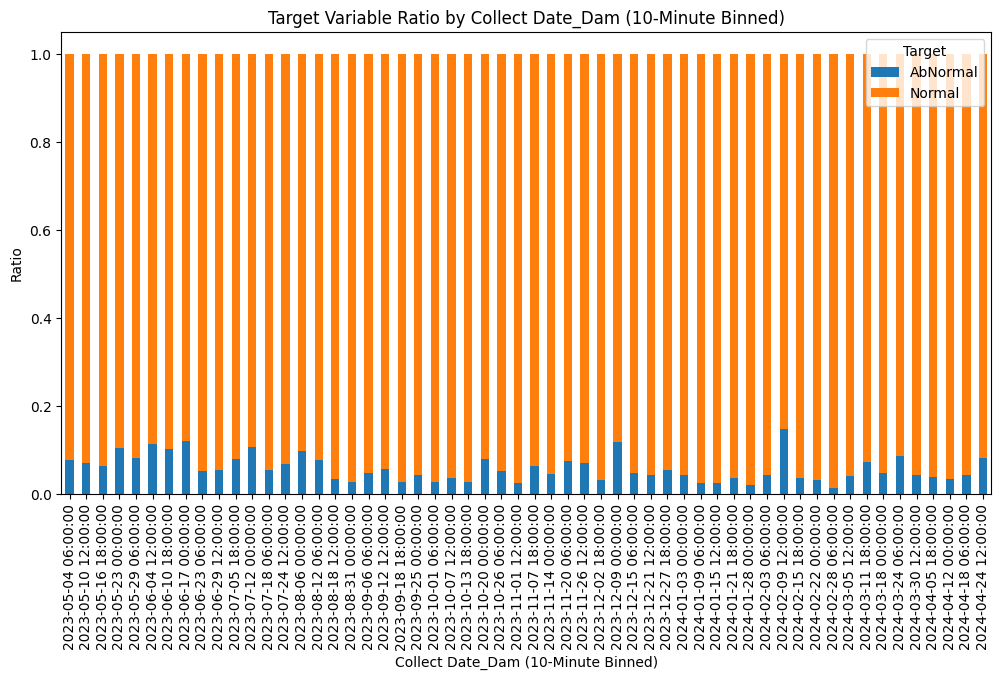

In [114]:
import pandas as pd
import matplotlib.pyplot as plt

# Collect Date_Dam 열을 datetime 형식으로 변환
train_data['Collect Date_Dam'] = pd.to_datetime(train_data['Collect Date_Dam'])

# Collect Date_Dam 값을 10분 간격으로 구간 나누기
train_data['Collect Date_Dam_binned'] = train_data['Collect Date_Dam'].dt.floor('9000T')

# 각 구간에 따른 target 변수의 비율 계산
target_ratio_by_date_binned = train_data.groupby('Collect Date_Dam_binned')['target'].value_counts(normalize=True).unstack()

# 막대그래프 시각화
target_ratio_by_date_binned.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Target Variable Ratio by Collect Date_Dam (10-Minute Binned)')
plt.xlabel('Collect Date_Dam (10-Minute Binned)')
plt.ylabel('Ratio')
plt.legend(title='Target')
plt.show()

In [109]:
# 4개의 변수만을 선택하여 head()로 확인
selected_columns = ['Collect Date_Dam']
print(train_data[selected_columns].tail(10))

          Collect Date_Dam
40496  2023-06-07 21:50:00
40497  2023-06-25 09:50:00
40498  2023-06-23 19:40:00
40499  2024-03-05 10:40:00
40500  2023-11-03 14:40:00
40501  2023-09-14 15:50:00
40502  2024-04-10 14:20:00
40503  2024-02-22 08:40:00
40504  2023-07-25 11:00:00
40505  2023-05-31 01:40:00


In [53]:
summarize_group(train_data, [
    'Collect Date_Dam'
    , 'Collect Date_Fill1'
    , 'Collect Date_Fill2'
    , 'Collect Date_AutoClave'
    ])

Grouped by: Collect Date_Dam, Collect Date_Fill1, Collect Date_Fill2, Collect Date_AutoClave

                                                   group  'AdNormal' count  \
0      (2023-05-04 09:10:00, 2023-05-04 09:10:00, 202...                 1   
1      (2023-05-04 09:10:00, 2023-05-04 09:20:00, 202...                 1   
2      (2023-05-04 09:20:00, 2023-05-04 09:20:00, 202...                 1   
3      (2023-05-04 11:20:00, 2023-05-04 11:20:00, 202...                 1   
4      (2023-05-05 09:40:00, 2023-05-05 09:40:00, 202...                 1   
...                                                  ...               ...   
21803  (2024-04-28 18:20:00, 2024-04-28 18:20:00, 202...                 0   
21804  (2024-04-28 18:20:00, 2024-04-28 18:20:00, 202...                 0   
21805  (2024-04-28 18:20:00, 2024-04-28 18:30:00, 202...                 0   
21806  (2024-04-28 18:30:00, 2024-04-28 18:30:00, 202...                 0   
21807  (2024-04-28 18:30:00, 2024-04-28 18:40:00

Wip Line

In [54]:
# 'Wip Line'를 포함하는 열 이름 필터링
filter_col = train_data.filter(like='Wip Line').columns

print("< Wip Line 포함 변수 >")
for col in filter_col:
    print(col)

< Wip Line 포함 변수 >
Wip Line_Dam
Wip Line_AutoClave
Wip Line_Fill1
Wip Line_Fill2


In [55]:
summarize_group(train_data, ['Wip Line_Dam'
                             , 'Wip Line_AutoClave'
                             , 'Wip Line_Fill1'
                             , 'Wip Line_Fill2'])

Grouped by: Wip Line_Dam, Wip Line_AutoClave, Wip Line_Fill1, Wip Line_Fill2

                                  group  'AdNormal' count     ratio  Total
0  (IVI-OB6, IVI-OB6, IVI-OB6, IVI-OB6)              2350  0.058016  40506


In [56]:
# Wip Line 열 제거
wip_line_columns = train_data.filter(like='Wip Line').columns

train_data.drop(columns=wip_line_columns, inplace=True)
test_data.drop(columns=wip_line_columns, inplace=True)

Process Desc

In [57]:
# 'Process Desc'를 포함하는 열 이름 필터링
filter_col = train_data.filter(like='Process Desc').columns

print("< Process Desc 포함 변수 >")
for col in filter_col:
    print(col)

< Process Desc 포함 변수 >
Process Desc._Dam
Process Desc._AutoClave
Process Desc._Fill1
Process Desc._Fill2


In [58]:
summarize_group(train_data, ['Process Desc._Dam'
                             , 'Process Desc._AutoClave'
                            #  , 'Process Desc._Fill1'
                             , 'Process Desc._Fill2'])

Grouped by: Process Desc._Dam, Process Desc._AutoClave, Process Desc._Fill2

                                              group  'AdNormal' count  \
0  (Dam Dispenser, Auto Clave Out, Fill2 Dispenser)              2350   

      ratio  Total  
0  0.058016  40506  


In [59]:
# Process Desc 열 제거
Process_Desc_col = train_data.filter(like='Process Desc').columns

train_data.drop(columns=Process_Desc_col, inplace=True)
test_data.drop(columns=Process_Desc_col, inplace=True)

Insp. Seq No

In [60]:
# 'Insp. Seq No'를 포함하는 열 이름 필터링
filter_col = train_data.filter(like='Insp. Seq No').columns

print("< Insp. Seq No 포함 변수 >")
for col in filter_col:
    print(col)

< Insp. Seq No 포함 변수 >
Insp. Seq No._Dam
Insp. Seq No._AutoClave
Insp. Seq No._Fill1
Insp. Seq No._Fill2


In [61]:
summarize_group(train_data, ['Insp. Seq No._Dam'
                             , 'Insp. Seq No._AutoClave'
                             , 'Insp. Seq No._Fill1'
                             , 'Insp. Seq No._Fill2'])

Grouped by: Insp. Seq No._Dam, Insp. Seq No._AutoClave, Insp. Seq No._Fill1, Insp. Seq No._Fill2

          group  'AdNormal' count     ratio  Total
0  (1, 1, 1, 1)              2350  0.058016  40506


In [62]:
# Insp. Seq No 열 제거
Insp_Seq_No_col = train_data.filter(like='Insp. Seq No').columns

train_data.drop(columns=Insp_Seq_No_col, inplace=True)
test_data.drop(columns=Insp_Seq_No_col, inplace=True)

In [63]:
# 'Insp Judge Code'를 포함하는 열 이름 필터링
filter_col = train_data.filter(like='Insp Judge Code').columns

print("< Insp Judge Code 포함 변수 >")
for col in filter_col:
    print(col)

< Insp Judge Code 포함 변수 >
Insp Judge Code_Dam
Insp Judge Code_AutoClave
Insp Judge Code_Fill1
Insp Judge Code_Fill2


In [64]:
summarize_group(train_data, ['Insp Judge Code_Dam'
                             , 'Insp Judge Code_AutoClave'
                             , 'Insp Judge Code_Fill1'
                             , 'Insp Judge Code_Fill2'])

Grouped by: Insp Judge Code_Dam, Insp Judge Code_AutoClave, Insp Judge Code_Fill1, Insp Judge Code_Fill2

              group  'AdNormal' count     ratio  Total
0  (OK, OK, OK, OK)              2350  0.058016  40506


In [65]:
# Insp Judge Code 열 제거
Insp_Judge_Code_col = train_data.filter(like='Insp Judge Code').columns

train_data.drop(columns=Insp_Judge_Code_col, inplace=True)
test_data.drop(columns=Insp_Judge_Code_col, inplace=True)

In [66]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Columns: 175 entries, Equipment_Dam to date_comparison
dtypes: float64(84), int64(64), object(27)
memory usage: 54.1+ MB


### 2. 제품 구분

- receip no, workorder, model.suffix

Receip_No

In [67]:
# 'Receip No'를 포함하는 열 이름 필터링
filter_col = train_data.filter(like='Receip No').columns

print("< Receip No 포함 변수 >")
for col in filter_col:
    print(col)

< Receip No 포함 변수 >
Receip No Collect Result_Dam
Receip No Collect Result_Fill1
Receip No Collect Result_Fill2


In [68]:
summarize_group(train_data, ['Receip No Collect Result_Dam'
                             , 'Receip No Collect Result_Fill1'
                             , 'Receip No Collect Result_Fill2'])

Grouped by: Receip No Collect Result_Dam, Receip No Collect Result_Fill1, Receip No Collect Result_Fill2

          group  'AdNormal' count     ratio  Total
0     (1, 1, 1)              2215  0.056396  39276
1     (1, 4, 1)                 1  1.000000      1
2     (1, 6, 6)                 3  1.000000      3
3     (3, 3, 3)                43  0.671875     64
4     (6, 6, 6)                82  0.083673    980
5     (9, 9, 9)                 1  0.010417     96
6  (17, 17, 17)                 5  0.058140     86


In [69]:
### Receip_No
# 파생변수 생성: Receip_No 3개의 컬럼 값이 모두 동일하면 해당 값을 저장, 아니면 diff
train_data['Receip_No'] = train_data.apply(
    lambda row: row['Receip No Collect Result_Dam'] if (row['Receip No Collect Result_Dam'] == row['Receip No Collect Result_Fill1'] == row['Receip No Collect Result_Fill2']) else 'diff',
    axis=1
)
test_data['Receip_No'] = test_data.apply(
    lambda row: row['Receip No Collect Result_Dam'] if (row['Receip No Collect Result_Dam'] == row['Receip No Collect Result_Fill1'] == row['Receip No Collect Result_Fill2']) else 'diff',
    axis=1
)

# receip_no 열을 object 타입으로 변경
train_data['Receip_No'] = train_data['Receip_No'].astype('object')
test_data['Receip_No'] = test_data['Receip_No'].astype('object')

# 필요없는 변수 삭제
train_data = train_data.drop(columns=['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1', 'Receip No Collect Result_Fill2'])
test_data = test_data.drop(columns=['Receip No Collect Result_Dam', 'Receip No Collect Result_Fill1', 'Receip No Collect Result_Fill2'])

In [70]:
value_counts_ratio(train_data, 'Receip_No')


Receip_No별 target 비율 및 갯수

          AbNormal    Normal  AbNormal   Normal  Total
variable                                              
1         0.056396  0.943604    2215.0  37061.0  39276
3         0.671875  0.328125      43.0     21.0     64
6         0.083673  0.916327      82.0    898.0    980
9         0.010417  0.989583       1.0     95.0     96
17        0.058140  0.941860       5.0     81.0     86
diff      1.000000  0.000000       4.0      0.0      4


model_suffix

In [71]:
summarize_group(train_data, ['Model.Suffix_Dam'
                             , 'Model.Suffix_AutoClave'
                            #  , 'Model.Suffix_Fill1' # 보기편하려고 주석처리한거
                             , 'Model.Suffix_Fill2'])

Grouped by: Model.Suffix_Dam, Model.Suffix_AutoClave, Model.Suffix_Fill2

                                     group  'AdNormal' count     ratio  Total
0  (AJX75334501, AJX75334501, AJX75334501)              1918  0.056712  33820
1  (AJX75334502, AJX75334502, AJX75334502)               230  0.067847   3390
2  (AJX75334503, AJX75334503, AJX75334503)                44  0.271605    162
3  (AJX75334505, AJX75334505, AJX75334505)               130  0.049336   2635
4  (AJX75334506, AJX75334506, AJX75334506)                 8  0.062016    129
5  (AJX75334507, AJX75334507, AJX75334507)                18  0.058065    310
6  (AJX75334508, AJX75334508, AJX75334508)                 2  0.033333     60


In [72]:
# 열 이름 변경
train_data.rename(columns={'Model.Suffix_Dam': 'model_suffix'}, inplace=True)
test_data.rename(columns={'Model.Suffix_Dam': 'model_suffix'}, inplace=True)

# 필요없는 변수 삭제
train_data = train_data.drop(columns=['Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2'])
test_data = test_data.drop(columns=['Model.Suffix_AutoClave', 'Model.Suffix_Fill1', 'Model.Suffix_Fill2'])

In [73]:
value_counts_ratio(train_data, 'model_suffix')


model_suffix별 target 비율 및 갯수

             AbNormal    Normal  AbNormal  Normal  Total
variable                                                
AJX75334501  0.056712  0.943288      1918   31902  33820
AJX75334502  0.067847  0.932153       230    3160   3390
AJX75334503  0.271605  0.728395        44     118    162
AJX75334505  0.049336  0.950664       130    2505   2635
AJX75334506  0.062016  0.937984         8     121    129
AJX75334507  0.058065  0.941935        18     292    310
AJX75334508  0.033333  0.966667         2      58     60


Workorder

In [74]:
# 'Workorder'를 포함하는 열 이름 필터링
filter_col = train_data.filter(like='Workorder').columns

print("< Workorder 포함 변수 >")
for col in filter_col:
    print(col)

< Workorder 포함 변수 >
Workorder_Dam
Workorder_AutoClave
Workorder_Fill1
Workorder_Fill2


In [75]:
value_counts_ratio(train_data, 'Workorder_Dam')


Workorder_Dam별 target 비율 및 갯수

            AbNormal    Normal  AbNormal  Normal  Total
variable                                               
3F1X5847-2  0.113208  0.886792      12.0    94.0    106
3F1X9643-1  0.047619  0.952381       7.0   140.0    147
3F1X9644-1  0.101911  0.898089      16.0   141.0    157
3F1X9648-1  0.062500  0.937500      10.0   150.0    160
3F1X9648-2  0.055556  0.944444       1.0    17.0     18
...              ...       ...       ...     ...    ...
4F1XB043-1  0.037037  0.962963       1.0    26.0     27
4F1XB596-1  0.020833  0.979167       3.0   141.0    144
4F1XB738-1  0.000000  1.000000       0.0    18.0     18
4F1XB758-1  0.025974  0.974026       2.0    75.0     77
4F1XB758-2  0.222222  0.777778      10.0    35.0     45

[663 rows x 5 columns]


In [76]:
summarize_group(train_data, ['Workorder_Dam'
                             , 'Workorder_AutoClave'
                             , 'Workorder_Fill1'
                             , 'Workorder_Fill2'])

Grouped by: Workorder_Dam, Workorder_AutoClave, Workorder_Fill1, Workorder_Fill2

                                                group  'AdNormal' count  \
0    (3F1X5847-2, 3F1X5847-2, 3F1X5847-2, 3F1X5847-2)                12   
1    (3F1X9643-1, 3F1X9643-1, 3F1X9643-1, 3F1X9643-1)                 7   
2    (3F1X9644-1, 3F1X9644-1, 3F1X9644-1, 3F1X9644-1)                16   
3    (3F1X9648-1, 3F1X9648-1, 3F1X9648-1, 3F1X9648-1)                10   
4    (3F1X9648-2, 3F1X9648-2, 3F1X9648-2, 3F1X9648-2)                 1   
..                                                ...               ...   
658  (4F1XB043-1, 4F1XB043-1, 4F1XB043-1, 4F1XB043-1)                 1   
659  (4F1XB596-1, 4F1XB596-1, 4F1XB596-1, 4F1XB596-1)                 3   
660  (4F1XB738-1, 4F1XB738-1, 4F1XB738-1, 4F1XB738-1)                 0   
661  (4F1XB758-1, 4F1XB758-1, 4F1XB758-1, 4F1XB758-1)                 2   
662  (4F1XB758-2, 4F1XB758-2, 4F1XB758-2, 4F1XB758-2)                10   

        ratio  To

In [77]:
summarize_group(train_data, ['Workorder_Dam'
                             , 'Workorder_AutoClave'
                             , 'Workorder_Fill1'
                             , 'Workorder_Fill2'])

Grouped by: Workorder_Dam, Workorder_AutoClave, Workorder_Fill1, Workorder_Fill2

                                                group  'AdNormal' count  \
0    (3F1X5847-2, 3F1X5847-2, 3F1X5847-2, 3F1X5847-2)                12   
1    (3F1X9643-1, 3F1X9643-1, 3F1X9643-1, 3F1X9643-1)                 7   
2    (3F1X9644-1, 3F1X9644-1, 3F1X9644-1, 3F1X9644-1)                16   
3    (3F1X9648-1, 3F1X9648-1, 3F1X9648-1, 3F1X9648-1)                10   
4    (3F1X9648-2, 3F1X9648-2, 3F1X9648-2, 3F1X9648-2)                 1   
..                                                ...               ...   
658  (4F1XB043-1, 4F1XB043-1, 4F1XB043-1, 4F1XB043-1)                 1   
659  (4F1XB596-1, 4F1XB596-1, 4F1XB596-1, 4F1XB596-1)                 3   
660  (4F1XB738-1, 4F1XB738-1, 4F1XB738-1, 4F1XB738-1)                 0   
661  (4F1XB758-1, 4F1XB758-1, 4F1XB758-1, 4F1XB758-1)                 2   
662  (4F1XB758-2, 4F1XB758-2, 4F1XB758-2, 4F1XB758-2)                10   

        ratio  To

Workorder_Dam 하나만 보았을때랑 Workorder 시리즈 여러개 보았을때 고윳값 갯수(663) 동일

In [78]:
### workorder
# Workorder -뒤의 번호 구분을 제거
train_data['cleaned_workorder'] = train_data['Workorder_Dam'].str.split('-').str[0]
test_data['cleaned_workorder'] = test_data['Workorder_Dam'].str.split('-').str[0]

# 필요없는 변수 삭제
train_data = train_data.drop(columns=['Workorder_Dam', 'Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2'])
test_data = test_data.drop(columns=['Workorder_Dam', 'Workorder_AutoClave', 'Workorder_Fill1', 'Workorder_Fill2'])

In [79]:
value_counts_ratio(train_data, 'cleaned_workorder')


cleaned_workorder별 target 비율 및 갯수

          AbNormal    Normal  AbNormal  Normal  Total
variable                                             
3F1X5847  0.113208  0.886792      12.0    94.0    106
3F1X9643  0.047619  0.952381       7.0   140.0    147
3F1X9644  0.101911  0.898089      16.0   141.0    157
3F1X9648  0.061798  0.938202      11.0   167.0    178
3F1XA350  0.070588  0.929412      12.0   158.0    170
...            ...       ...       ...     ...    ...
4F1XA938  0.158416  0.841584      16.0    85.0    101
4F1XB043  0.037037  0.962963       1.0    26.0     27
4F1XB596  0.020833  0.979167       3.0   141.0    144
4F1XB738  0.000000  1.000000       0.0    18.0     18
4F1XB758  0.098361  0.901639      12.0   110.0    122

[568 rows x 5 columns]


### 3. 공통 변수 (dam, fill1, fill2)

- workmode

In [80]:
# 'WorkMode'를 포함하는 열 이름 필터링
filter_col = train_data.filter(like='WorkMode').columns

print("< WorkMode 포함 변수 >")
for col in filter_col:
    print(col)

< WorkMode 포함 변수 >
WorkMode Collect Result_Dam
WorkMode Collect Result_Fill1
WorkMode Collect Result_Fill2


In [81]:
summarize_group(train_data, ['WorkMode Collect Result_Dam'
                             , 'WorkMode Collect Result_Fill1'
                             , 'WorkMode Collect Result_Fill2'])

Grouped by: WorkMode Collect Result_Dam, WorkMode Collect Result_Fill1, WorkMode Collect Result_Fill2

             group  'AdNormal' count     ratio  Total
0  (7.0, 7.0, 0.0)              1206  0.073326  16447


In [82]:
# WorkMode Collect Result_Dam의 이름을 WorkMode Collect Result로 변경
train_data = train_data.rename(columns={'WorkMode Collect Result_Dam': 'WorkMode Collect Result'})
test_data = test_data.rename(columns={'WorkMode Collect Result_Dam': 'WorkMode Collect Result'})

# WorkMode Collect Result_Fill1, WorkMode Collect Result_Fill2 열 드롭
train_data = train_data.drop(columns=['WorkMode Collect Result_Fill1', 'WorkMode Collect Result_Fill2'])
test_data = test_data.drop(columns=['WorkMode Collect Result_Fill1', 'WorkMode Collect Result_Fill2'])

In [83]:
value_counts_ratio(train_data, 'WorkMode Collect Result')


WorkMode Collect Result별 target 비율 및 갯수

          AbNormal    Normal  AbNormal  Normal  Total
variable                                             
7.0       0.073326  0.926674      1206   15241  16447


In [84]:
# WorkMode Collect Result 열의 값이 7인 행을 1로 변경
train_data['WorkMode Collect Result'] = train_data['WorkMode Collect Result'].replace(7, 1)
test_data['WorkMode Collect Result'] = test_data['WorkMode Collect Result'].replace(7, 1)

# WorkMode Collect Result 열의 결측값을 0으로 채움
train_data['WorkMode Collect Result'] = train_data['WorkMode Collect Result'].fillna(0)
test_data['WorkMode Collect Result'] = test_data['WorkMode Collect Result'].fillna(0)

In [85]:
value_counts_ratio(train_data, 'WorkMode Collect Result')


WorkMode Collect Result별 target 비율 및 갯수

          AbNormal    Normal  AbNormal  Normal  Total
variable                                             
0.0       0.047550  0.952450      1144   22915  24059
1.0       0.073326  0.926674      1206   15241  16447


- equipment
<br>(dispenser1 & dispenser2 변수를 만들 경우 다른 변수들에 의해 이미 설명이 되는 변수라 상관계수가 너무 높아서 제거하게 됨. 따라서 equipment가 같은지만 판단하는 파생변수 사용)

In [86]:
# 'Equipment'를 포함하는 열 이름 필터링
filter_col = train_data.filter(like='Equipment').columns

print("< Equipment 포함 변수 >")
for col in filter_col:
    print(col)

< Equipment 포함 변수 >
Equipment_Dam
Equipment_AutoClave
Equipment_Fill1
Equipment_Fill2


In [87]:
summarize_group(train_data, ['Equipment_Dam'
                             , 'Equipment_AutoClave'
                             , 'Equipment_Fill1'
                             , 'Equipment_Fill2'])

Grouped by: Equipment_Dam, Equipment_AutoClave, Equipment_Fill1, Equipment_Fill2

                                               group  'AdNormal' count  \
0  (Dam dispenser #1, Auto Clave Out, Fill1 dispe...              1466   
1  (Dam dispenser #1, Auto Clave Out, Fill1 dispe...                 6   
2  (Dam dispenser #1, Auto Clave Out, Fill1 dispe...                13   
3  (Dam dispenser #2, Auto Clave Out, Fill1 dispe...                10   
4  (Dam dispenser #2, Auto Clave Out, Fill1 dispe...                 5   
5  (Dam dispenser #2, Auto Clave Out, Fill1 dispe...               850   

      ratio  Total  
0  0.058614  25011  
1  1.000000      6  
2  1.000000     13  
3  1.000000     10  
4  1.000000      5  
5  0.054977  15461  


#1 #2가 서로 다른 dispenser인 경우 무조건 불량(AdNormal)발생

In [595]:
# # Equipment로 시작하는 열 필터링
# Equipment_col = train_data.filter(like='Equipment').columns
# Equipment_col2 = test_data.filter(like='Equipment').columns

# new_train = train_data.filter(items=Equipment_col)
# new_test = test_data.filter(items=Equipment_col2)

# # Equipment_same_num 파생변수 생성
# def determine_equipment_same_num(row):
#     if (row['Equipment_Dam'] == 'Dam dispenser #1' and row['Equipment_AutoClave'] == 'Auto Clave Out' and 
#         row['Equipment_Fill1'] == 'Fill1 dispenser #1' and row['Equipment_Fill2'] == 'Fill2 dispenser #1') or \
#        (row['Equipment_Dam'] == 'Dam dispenser #2' and row['Equipment_AutoClave'] == 'Auto Clave Out' and 
#         row['Equipment_Fill1'] == 'Fill1 dispenser #2' and row['Equipment_Fill2'] == 'Fill2 dispenser #2'):
#         return 1
#     else:
#         return 0

# train_data['Equipment_same_num'] = new_train.apply(determine_equipment_same_num, axis=1)
# test_data['Equipment_same_num'] = new_test.apply(determine_equipment_same_num, axis=1)

# train_data = train_data.drop(columns=['Equipment_Dam', 'Equipment_AutoClave', 'Equipment_Fill1', 'Equipment_Fill2'])
# test_data = test_data.drop(columns=['Equipment_Dam', 'Equipment_AutoClave', 'Equipment_Fill1', 'Equipment_Fill2'])

In [88]:
# Equipment로 시작하는 열 필터링
Equipment_col = train_data.filter(like='Equipment').columns
Equipment_col2 = test_data.filter(like='Equipment').columns

new_train = train_data.filter(items=Equipment_col)
new_test = test_data.filter(items=Equipment_col2)

# Equipment_num 파생변수 생성
def determine_equipment_num(row):
    if (row['Equipment_Dam'] == 'Dam dispenser #1' and row['Equipment_AutoClave'] == 'Auto Clave Out' and 
        row['Equipment_Fill1'] == 'Fill1 dispenser #1' and row['Equipment_Fill2'] == 'Fill2 dispenser #1'):
        return '#1'
    elif (row['Equipment_Dam'] == 'Dam dispenser #2' and row['Equipment_AutoClave'] == 'Auto Clave Out' and 
          row['Equipment_Fill1'] == 'Fill1 dispenser #2' and row['Equipment_Fill2'] == 'Fill2 dispenser #2'):
        return '#2'
    else:
        return 'diff'

train_data['Equipment_num'] = new_train.apply(determine_equipment_num, axis=1)
test_data['Equipment_num'] = new_test.apply(determine_equipment_num, axis=1)

# 불필요한 열 삭제
train_data = train_data.drop(columns=['Equipment_Dam', 'Equipment_AutoClave', 'Equipment_Fill1', 'Equipment_Fill2'])
test_data = test_data.drop(columns=['Equipment_Dam', 'Equipment_AutoClave', 'Equipment_Fill1', 'Equipment_Fill2'])

- palletID

In [89]:
# 'PalletID'를 포함하는 열 이름 필터링
filter_col = train_data.filter(like='PalletID').columns

print("< PalletID 포함 변수 >")
for col in filter_col:
    print(col)

< PalletID 포함 변수 >
PalletID Collect Result_Dam
PalletID Collect Result_Fill1
PalletID Collect Result_Fill2


In [90]:
summarize_group(train_data, ['PalletID Collect Result_Dam'
                             , 'PalletID Collect Result_Fill1'
                             , 'PalletID Collect Result_Fill2'])

Grouped by: PalletID Collect Result_Dam, PalletID Collect Result_Fill1, PalletID Collect Result_Fill2

                 group  'AdNormal' count     ratio  Total
0      (1.0, 1.0, 1.0)               162  0.051494   3146
1      (1.0, 1.0, 4.0)                 1  1.000000      1
2      (1.0, 1.0, 7.0)                 1  1.000000      1
3      (1.0, 1.0, 9.0)                 1  1.000000      1
4      (1.0, 2.0, 2.0)                 1  1.000000      1
..                 ...               ...       ...    ...
87  (16.0, 10.0, 10.0)                 1  1.000000      1
88  (16.0, 15.0, 15.0)                 1  1.000000      1
89   (16.0, 16.0, 8.0)                 1  1.000000      1
90  (16.0, 16.0, 11.0)                 1  1.000000      1
91  (16.0, 16.0, 16.0)               110  0.062007   1774

[92 rows x 4 columns]


In [91]:
# 세 변수의 값이 동일하면 해당 값을 가져가고, 하나라도 일치하지 않으면 diff의 값을 가지는 파생 변수 생성 함수
def create_palletid_collect_result(df):
    df['PalletID_Collect_Result'] = df.apply(
        lambda row: row['PalletID Collect Result_Dam'] 
                    if (row['PalletID Collect Result_Dam'] == row['PalletID Collect Result_Fill1'] == row['PalletID Collect Result_Fill2']) 
                    else 'diff', 
        axis=1
    )

# 함수 적용
create_palletid_collect_result(train_data)
create_palletid_collect_result(test_data)

In [92]:
# 제거할 변수 목록
columns_to_drop = [
    'PalletID Collect Result_Dam',
    'PalletID Collect Result_Fill1',
    'PalletID Collect Result_Fill2'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [93]:
value_counts_ratio(train_data, 'PalletID_Collect_Result')


PalletID_Collect_Result별 target 비율 및 갯수

          AbNormal    Normal  AbNormal  Normal  Total
variable                                             
1.0       0.051494  0.948506     162.0  2984.0   3146
2.0       0.066859  0.933141     209.0  2917.0   3126
3.0       0.063171  0.936829     200.0  2966.0   3166
4.0       0.053875  0.946125     171.0  3003.0   3174
5.0       0.054115  0.945885     167.0  2919.0   3086
6.0       0.058125  0.941875     181.0  2933.0   3114
7.0       0.052922  0.947078     163.0  2917.0   3080
8.0       0.057412  0.942588     177.0  2906.0   3083
9.0       0.045929  0.954071      88.0  1828.0   1916
10.0      0.051117  0.948883     103.0  1912.0   2015
11.0      0.057158  0.942842     109.0  1798.0   1907
12.0      0.042394  0.957606      85.0  1920.0   2005
13.0      0.068766  0.931234     131.0  1774.0   1905
14.0      0.048485  0.951515      96.0  1884.0   1980
15.0      0.059096  0.940904     115.0  1831.0   1946
16.0      0.062007  0.937993     110.0  

- production Qty

In [94]:
# 'Production Qty'를 포함하는 열 이름 필터링
filter_col = train_data.filter(like='Production Qty').columns

print("< Production Qty 포함 변수 >")
for col in filter_col:
    print(col)

< Production Qty 포함 변수 >
Production Qty Collect Result_Dam
Production Qty Collect Result_Fill1
Production Qty Collect Result_Fill2


In [95]:
summarize_group(train_data, ['Production Qty Collect Result_Dam'
                                , 'Production Qty Collect Result_Fill1'
                                , 'Production Qty Collect Result_Fill2'])

Grouped by: Production Qty Collect Result_Dam, Production Qty Collect Result_Fill1, Production Qty Collect Result_Fill2

               group  'AdNormal' count     ratio  Total
0          (0, 0, 0)                13  0.141304     92
1         (0, 0, 12)                 1  1.000000      1
2        (0, 0, 300)                 1  1.000000      1
3          (0, 2, 2)                 1  1.000000      1
4        (0, 19, 19)                 1  1.000000      1
..               ...               ...       ...    ...
695  (604, 604, 604)                 0  0.000000      1
696  (605, 605, 605)                 0  0.000000      1
697  (606, 606, 606)                 0  0.000000      1
698  (607, 607, 607)                 0  0.000000      1
699  (608, 608, 608)                 0  0.000000      1

[700 rows x 4 columns]


In [96]:
# 세 변수의 값이 동일하면 해당 값을 가져가고, 하나라도 일치하지 않으면 diff의 값을 가지는 파생 변수 생성 함수
def create_palletid_collect_result(df):
    df['Production_Qty_Collect_Result'] = df.apply(
        lambda row: row['Production Qty Collect Result_Dam']
                    if (row['Production Qty Collect Result_Dam'] == row['Production Qty Collect Result_Fill1'] == row['Production Qty Collect Result_Fill2']) 
                    else -1, 
        axis=1
    )

# 함수 적용
create_palletid_collect_result(train_data)
create_palletid_collect_result(test_data)

plot을 그리기 위해 diff 대신에 -1 값을 넣어줬음

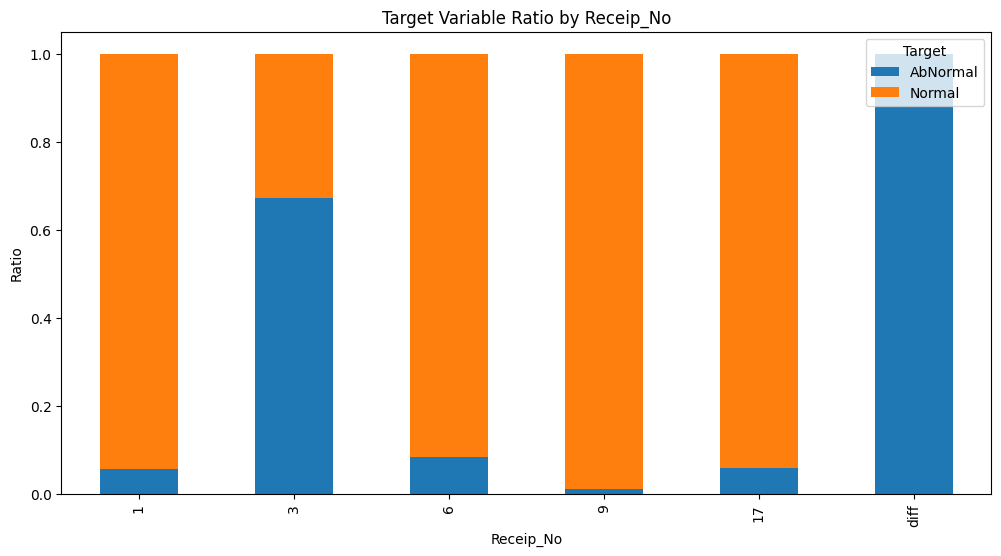

In [97]:
import pandas as pd
import matplotlib.pyplot as plt

# Production_Qty_Collect_Result 값에 따른 target 변수의 비율 계산
target_ratio_by_qty = train_data.groupby('Receip_No')['target'].value_counts(normalize=True).unstack()

# 막대그래프 시각화
target_ratio_by_qty.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Target Variable Ratio by Receip_No')
plt.xlabel('Receip_No')
plt.ylabel('Ratio')
plt.legend(title='Target')
plt.show()

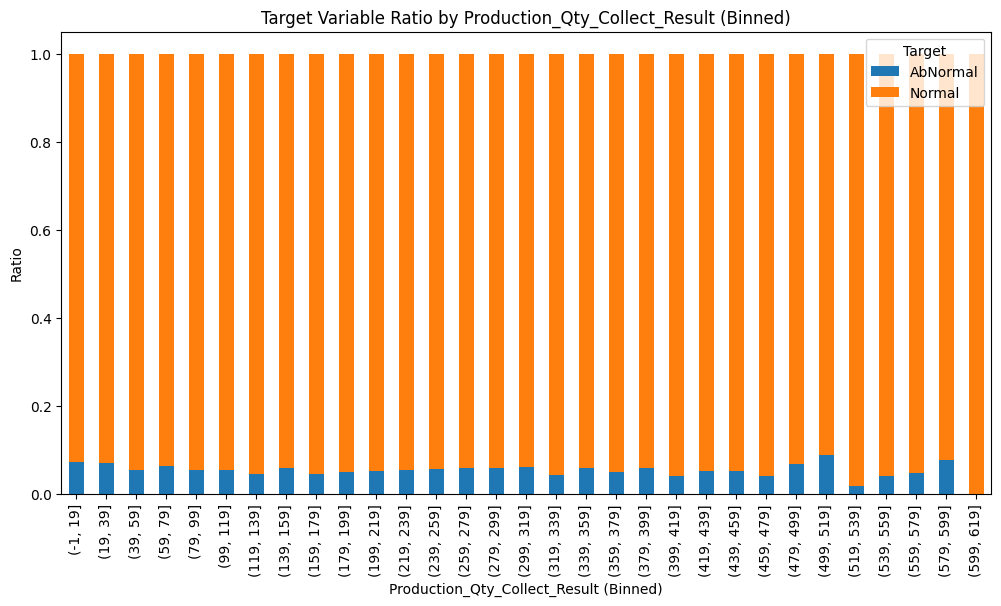

In [98]:
import pandas as pd
import matplotlib.pyplot as plt

# Production_Qty_Collect_Result 값을 10 단위로 구간 나누기 
# range(시작값(최솟값), 끝값(최댓값+20), 간격(20)) 형태
bins = range(int(train_data['Production_Qty_Collect_Result'].min()), 
             int(train_data['Production_Qty_Collect_Result'].max())+20, 20)
train_data['Production_Qty_Collect_Result_binned'] = pd.cut(train_data['Production_Qty_Collect_Result'], bins)

# 각 구간에 따른 target 변수의 비율 계산
target_ratio_by_qty_binned = train_data.groupby('Production_Qty_Collect_Result_binned')['target'].value_counts(normalize=True).unstack()

# 막대그래프 시각화
target_ratio_by_qty_binned.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Target Variable Ratio by Production_Qty_Collect_Result (Binned)')
plt.xlabel('Production_Qty_Collect_Result (Binned)')
plt.ylabel('Ratio')
plt.legend(title='Target')
plt.show()

In [607]:
value_counts_ratio(train_data, 'Production_Qty_Collect_Result')                 


Production_Qty_Collect_Result별 target 비율 및 갯수

          AbNormal    Normal  AbNormal  Normal  Total
variable                                             
-1        1.000000  0.000000      93.0     0.0     93
 0        0.141304  0.858696      13.0    79.0     92
 1        0.132075  0.867925      14.0    92.0    106
 2        0.059829  0.940171       7.0   110.0    117
 3        0.076271  0.923729       9.0   109.0    118
...            ...       ...       ...     ...    ...
 604      0.000000  1.000000       0.0     1.0      1
 605      0.000000  1.000000       0.0     1.0      1
 606      0.000000  1.000000       0.0     1.0      1
 607      0.000000  1.000000       0.0     1.0      1
 608      0.000000  1.000000       0.0     1.0      1

[608 rows x 5 columns]


In [608]:
# Production_Qty_Collect_Result가 -1인 경우 1을 부여하고 아닌 경우 0을 부여하는 파생변수 생성
train_data['Production_Qty_diff'] = train_data['Production_Qty_Collect_Result'].apply(lambda x: 1 if x == -1 else 0)
test_data['Production_Qty_diff'] = test_data['Production_Qty_Collect_Result'].apply(lambda x: 1 if x == -1 else 0)

<Figure size 1000x500 with 0 Axes>

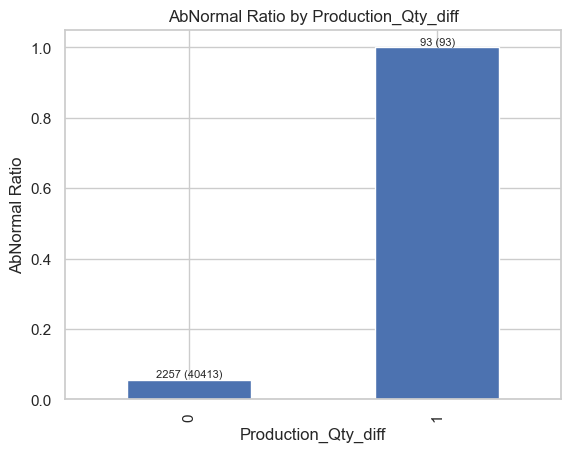

In [609]:
plot_ratio(train_data, 'Production_Qty_diff')

In [610]:
train_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 158 columns):
 #    Column                                                      Dtype   
---   ------                                                      -----   
 0    model_suffix                                                object  
 1    CURE END POSITION X Collect Result_Dam                      float64 
 2    CURE END POSITION Z Collect Result_Dam                      float64 
 3    CURE END POSITION Θ Collect Result_Dam                      int64   
 4    CURE SPEED Collect Result_Dam                               int64   
 5    CURE STANDBY POSITION X Collect Result_Dam                  int64   
 6    CURE STANDBY POSITION Z Collect Result_Dam                  float64 
 7    CURE STANDBY POSITION Θ Collect Result_Dam                  int64   
 8    CURE START POSITION X Collect Result_Dam                    int64   
 9    CURE START POSITION Z Collect Result_Dam                   

In [611]:
for_check_boxplot_data = train_data.copy()
for_check_boxplot_data['Production_Qty_Collect_Result'] = for_check_boxplot_data['Production_Qty_Collect_Result'].replace('diff', -1)

In [612]:
# 타겟 변수별로 이상치 갯수 세기
def count_outliers_by_target(df, target_col, value_col):
    outlier_counts = {}

    # 타겟 변수의 고유값을 가져오기
    targets = df[target_col].unique()
    
    for target in targets:
        # 해당 타겟에 대한 데이터 필터링
        target_data = df[df[target_col] == target]
        
        # Q1, Q3 계산
        Q1 = target_data[value_col].quantile(0.25)
        Q3 = target_data[value_col].quantile(0.75)
        IQR = Q3 - Q1
        
        # 이상치 기준 설정
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 이상치 갯수 세기
        outliers_count = target_data[(target_data[value_col] < lower_bound) | 
                                     (target_data[value_col] > upper_bound)].shape[0]
        
        # 결과 저장
        outlier_counts[target] = outliers_count

    return outlier_counts

# 함수 호출
outlier_counts = count_outliers_by_target(train_data, 'target', 'Production_Qty_Collect_Result')

# 결과 출력
print(outlier_counts)

{'Normal': 140, 'AbNormal': 5}


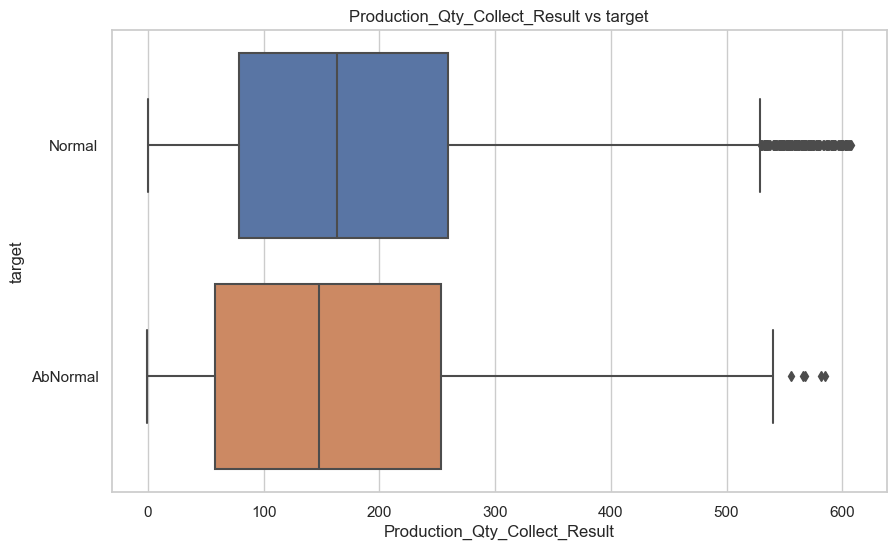

In [613]:
plot_ratio_boxplot(for_check_boxplot_data, 'Production_Qty_Collect_Result')

In [614]:
# Production_Qty_Collect_Result 값이 500 이상인 행 필터링
filtered_data = train_data[train_data['Production_Qty_Collect_Result'] >= 500]

# 필터링된 행의 갯수 출력
filtered_count = filtered_data.shape[0]
print(f"Filtered rows count: {filtered_count}")

# target 변수의 비율 계산
target_ratio = filtered_data['target'].value_counts(normalize=True)

# 비율 출력
print(target_ratio)

Filtered rows count: 289
Normal      0.944637
AbNormal    0.055363
Name: target, dtype: float64


In [615]:
# Production_Qty_Collect_Result 값이 500 이상인 행 필터링
filtered_data = train_data[train_data['Production_Qty_Collect_Result'] >= 600]

# 필터링된 행의 갯수 출력
filtered_count = filtered_data.shape[0]
print(f"Filtered rows count: {filtered_count}")

# target 변수의 비율 계산
target_ratio = filtered_data['target'].value_counts(normalize=True)

# 비율 출력
print(target_ratio)

Filtered rows count: 12
Normal    1.0
Name: target, dtype: float64


분포 차이 x

In [616]:
# 제거할 변수 목록
columns_to_drop = [
    'Production Qty Collect Result_Dam',
    'Production Qty Collect Result_Fill1',
    'Production Qty Collect Result_Fill2'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [617]:
train_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 155 columns):
 #    Column                                                      Dtype   
---   ------                                                      -----   
 0    model_suffix                                                object  
 1    CURE END POSITION X Collect Result_Dam                      float64 
 2    CURE END POSITION Z Collect Result_Dam                      float64 
 3    CURE END POSITION Θ Collect Result_Dam                      int64   
 4    CURE SPEED Collect Result_Dam                               int64   
 5    CURE STANDBY POSITION X Collect Result_Dam                  int64   
 6    CURE STANDBY POSITION Z Collect Result_Dam                  float64 
 7    CURE STANDBY POSITION Θ Collect Result_Dam                  int64   
 8    CURE START POSITION X Collect Result_Dam                    int64   
 9    CURE START POSITION Z Collect Result_Dam                   

In [618]:
value_counts_ratio(train_data, 'Receip_No')


Receip_No별 target 비율 및 갯수

          AbNormal    Normal  AbNormal   Normal  Total
variable                                              
1         0.056396  0.943604    2215.0  37061.0  39276
3         0.671875  0.328125      43.0     21.0     64
6         0.083673  0.916327      82.0    898.0    980
9         0.010417  0.989583       1.0     95.0     96
17        0.058140  0.941860       5.0     81.0     86
diff      1.000000  0.000000       4.0      0.0      4


In [619]:
value_counts_ratio(train_data, 'model_suffix')


model_suffix별 target 비율 및 갯수

             AbNormal    Normal  AbNormal  Normal  Total
variable                                                
AJX75334501  0.056712  0.943288      1918   31902  33820
AJX75334502  0.067847  0.932153       230    3160   3390
AJX75334503  0.271605  0.728395        44     118    162
AJX75334505  0.049336  0.950664       130    2505   2635
AJX75334506  0.062016  0.937984         8     121    129
AJX75334507  0.058065  0.941935        18     292    310
AJX75334508  0.033333  0.966667         2      58     60


<Figure size 1000x500 with 0 Axes>

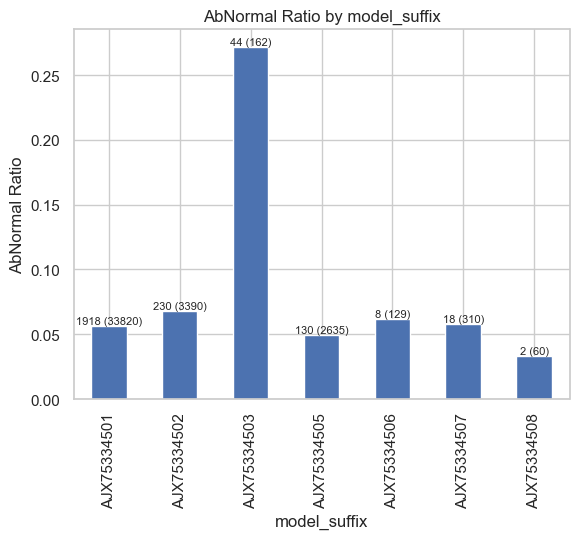

In [620]:
plot_ratio(train_data, 'model_suffix')

In [621]:
# model_suffix 값이 'AJX75334503'인 경우 1, 아닌 경우 0을 부여하는 파생변수 생성
train_data['model_suffix_03'] = train_data['model_suffix'].apply(lambda x: 1 if x == 'AJX75334503' else 0)
test_data['model_suffix_03'] = test_data['model_suffix'].apply(lambda x: 1 if x == 'AJX75334503' else 0)

<Figure size 1000x500 with 0 Axes>

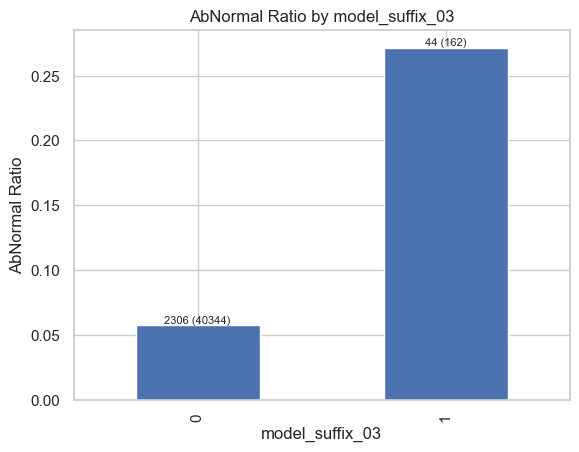

In [622]:
plot_ratio(train_data,'model_suffix_03')

<Figure size 1000x500 with 0 Axes>

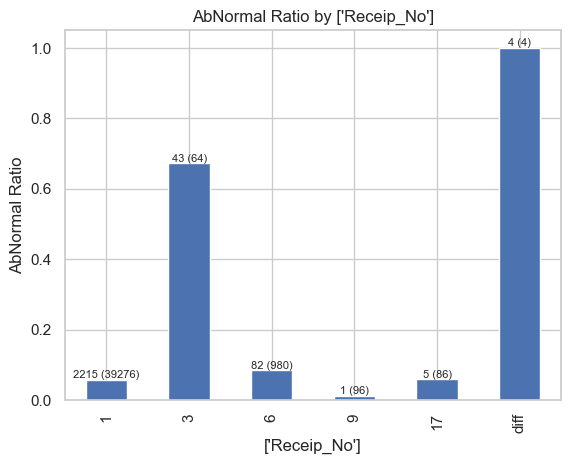

In [623]:
plot_ratio(train_data, [ 
   'Receip_No'
])

In [624]:
# Receip_No가 3이고 model_suffix_03이 1인 경우 가중치 1을 부여하고 아닌 경우 0을 부여하는 파생변수 생성
train_data['Receip_n_suffix_3'] = train_data.apply(lambda row: 1 if row['Receip_No'] == 3 and row['model_suffix_03'] == 1 else 0, axis=1)
test_data['Receip_n_suffix_3'] = test_data.apply(lambda row: 1 if row['Receip_No'] == 3 and row['model_suffix_03'] == 1 else 0, axis=1)

In [625]:
# model_suffix_03 변수 드랍
train_data = train_data.drop(columns=['model_suffix_03'])
test_data = test_data.drop(columns=['model_suffix_03'])

<Figure size 1000x500 with 0 Axes>

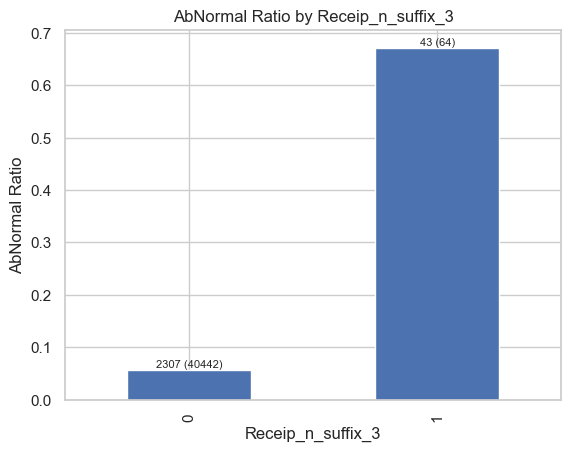

In [626]:
plot_ratio(train_data,'Receip_n_suffix_3')

<Figure size 1000x500 with 0 Axes>

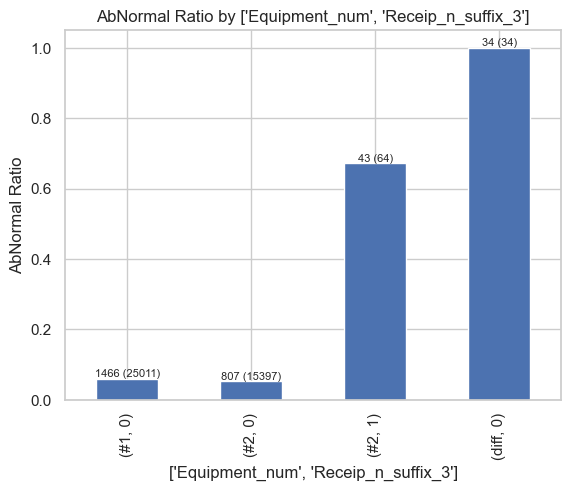

In [627]:
plot_ratio(train_data, [ 
   'Equipment_num'
    , 'Receip_n_suffix_3'
])

딱히 Equipment_num(dispneser #1, #2) 에 따라서 유의미한 정보 x

In [628]:
len(train_data.columns)

156

In [629]:
len(test_data.columns)

156

In [630]:
train_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 156 columns):
 #    Column                                                      Dtype   
---   ------                                                      -----   
 0    model_suffix                                                object  
 1    CURE END POSITION X Collect Result_Dam                      float64 
 2    CURE END POSITION Z Collect Result_Dam                      float64 
 3    CURE END POSITION Θ Collect Result_Dam                      int64   
 4    CURE SPEED Collect Result_Dam                               int64   
 5    CURE STANDBY POSITION X Collect Result_Dam                  int64   
 6    CURE STANDBY POSITION Z Collect Result_Dam                  float64 
 7    CURE STANDBY POSITION Θ Collect Result_Dam                  int64   
 8    CURE START POSITION X Collect Result_Dam                    int64   
 9    CURE START POSITION Z Collect Result_Dam                   

<Figure size 1000x500 with 0 Axes>

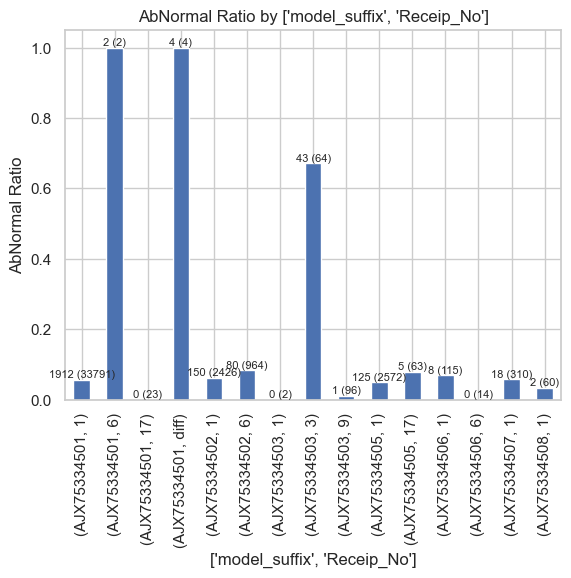

In [631]:
plot_ratio(train_data, [ 
    'model_suffix'
    , 'Receip_No'
    # , 'Receip_n_suffix_3'
])

<Figure size 1000x500 with 0 Axes>

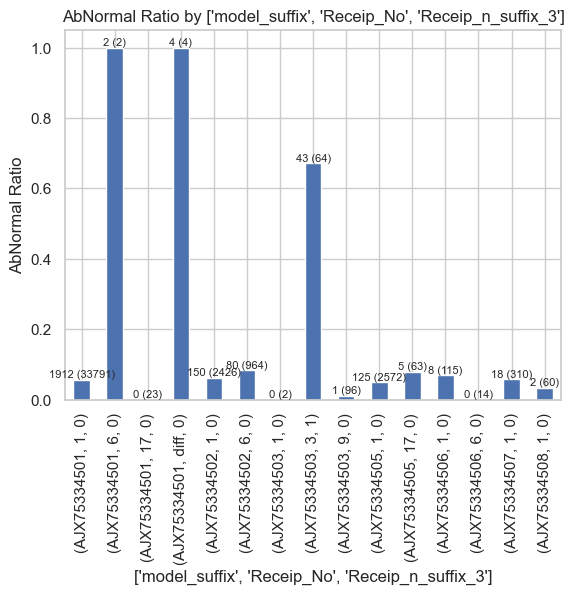

In [632]:
plot_ratio(train_data, [ 
    'model_suffix'
    , 'Receip_No'
    , 'Receip_n_suffix_3'
])

### 4. CURE 변수
- dam -> distance 파생변수 (standby는 단일값, start와 end는 값은 여러개지만 distance 파생변수를 만들었을 때 더 의미있었음)
- fill2 -> 변수값 범주화 (start, end, standby를 각각 범주화했을 때가 합쳐서 distance 만들었을 때보다 더 의미있었음)

In [633]:
train_data.columns

Index(['model_suffix', 'CURE END POSITION X Collect Result_Dam',
       'CURE END POSITION Z Collect Result_Dam',
       'CURE END POSITION Θ Collect Result_Dam',
       'CURE SPEED Collect Result_Dam',
       'CURE STANDBY POSITION X Collect Result_Dam',
       'CURE STANDBY POSITION Z Collect Result_Dam',
       'CURE STANDBY POSITION Θ Collect Result_Dam',
       'CURE START POSITION X Collect Result_Dam',
       'CURE START POSITION Z Collect Result_Dam',
       ...
       'Machine Tact time Collect Result_Fill2', 'target', 'Receip_No',
       'cleaned_workorder', 'Equipment_num', 'PalletID_Collect_Result',
       'Production_Qty_Collect_Result', 'Production_Qty_Collect_Result_binned',
       'Production_Qty_diff', 'Receip_n_suffix_3'],
      dtype='object', length=156)

In [634]:
summarize_group(train_data, ['Equipment_num'
                             , 'CURE START POSITION X Collect Result_Dam'
                             , 'CURE END POSITION X Collect Result_Dam'
                             , 'CURE END POSITION Z Collect Result_Dam'])

Grouped by: Equipment_num, CURE START POSITION X Collect Result_Dam, CURE END POSITION X Collect Result_Dam, CURE END POSITION Z Collect Result_Dam

                       group  'AdNormal' count     ratio  Total
0     (#1, 1030, 240.0, 2.5)              1466  0.058614  25011
1    (#2, 280, 1000.0, 12.5)               850  0.054977  15461
2  (diff, 280, 1000.0, 12.5)                15  1.000000     15
3   (diff, 1030, 240.0, 2.5)                19  1.000000     19


In [635]:
### dam
# 시작 위치와 끝 위치 열 이름
start_x_col = 'CURE START POSITION X Collect Result_Dam'
start_z_col = 33.5
end_x_col = 'CURE END POSITION X Collect Result_Dam'
end_z_col = 'CURE END POSITION Z Collect Result_Dam'

# 시작 위치와 끝 위치 사이의 거리 계산
train_data['CURE_DISTANCE_Dam'] = np.sqrt(
    (train_data[end_x_col] - train_data[start_x_col]) ** 2 +
    (train_data[end_z_col] - start_z_col) ** 2
)

test_data['CURE_DISTANCE_Dam'] = np.sqrt(
    (train_data[end_x_col] - train_data[start_x_col]) ** 2 +
    (train_data[end_z_col] - start_z_col) ** 2
)

In [636]:
value_counts_ratio(train_data, 'CURE_DISTANCE_Dam')


CURE_DISTANCE_Dam별 target 비율 및 갯수

            AbNormal    Normal  AbNormal  Normal  Total
variable                                               
720.306185  0.055893  0.944107       865   14611  15476
790.607994  0.059329  0.940671      1485   23545  25030


In [637]:
summarize_group(train_data, ['Equipment_num'
                             , 'CURE_DISTANCE_Dam'])

Grouped by: Equipment_num, CURE_DISTANCE_Dam

                       group  'AdNormal' count     ratio  Total
0     (#1, 790.607993888248)              1466  0.058614  25011
1    (#2, 720.3061848963953)               850  0.054977  15461
2  (diff, 720.3061848963953)                15  1.000000     15
3   (diff, 790.607993888248)                19  1.000000     19


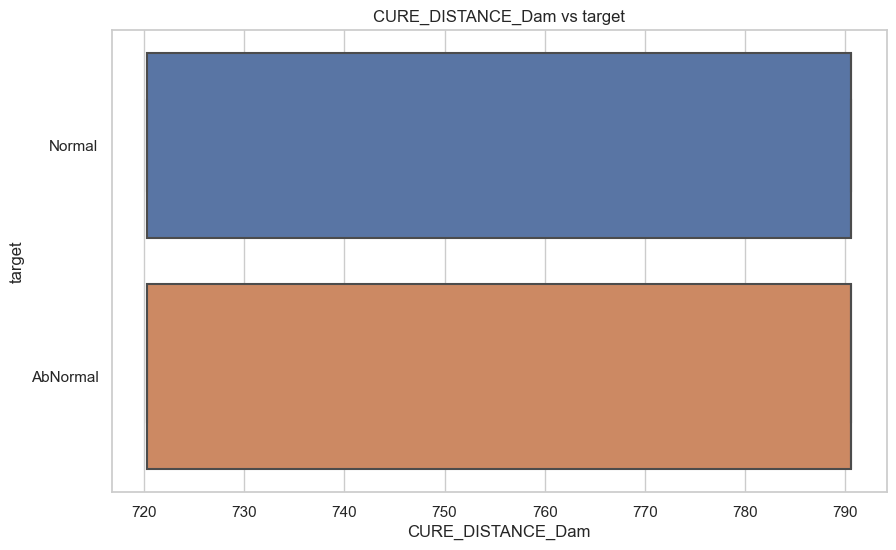

In [638]:
plot_ratio_boxplot(train_data, 'CURE_DISTANCE_Dam')

In [639]:
summarize_group(train_data, ['Equipment_num'
                             , 'CURE END POSITION X Collect Result_Fill2'
                             , 'CURE END POSITION Z Collect Result_Fill2'
                             , 'CURE START POSITION X Collect Result_Fill2'
                             , 'CURE START POSITION Z Collect Result_Fill2'
                             , 'CURE STANDBY POSITION X Collect Result_Fill2'
                             , 'CURE STANDBY POSITION Z Collect Result_Fill2'])

Grouped by: Equipment_num, CURE END POSITION X Collect Result_Fill2, CURE END POSITION Z Collect Result_Fill2, CURE START POSITION X Collect Result_Fill2, CURE START POSITION Z Collect Result_Fill2, CURE STANDBY POSITION X Collect Result_Fill2, CURE STANDBY POSITION Z Collect Result_Fill2

                                  group  'AdNormal' count     ratio  Total
0     (#1, 240, 22, 1020, 22, 1020, 22)                 5  0.055556     90
1     (#1, 240, 32, 1020, 22, 1020, 22)                29  0.077540    374
2     (#1, 240, 32, 1020, 32, 1020, 32)               367  0.093934   3907
3     (#1, 240, 32, 1020, 33, 1020, 33)               255  0.084549   3016
4     (#1, 240, 33, 1020, 23, 1020, 23)                22  0.107843    204
5     (#1, 240, 33, 1020, 32, 1020, 32)                31  0.046269    670
6     (#1, 240, 33, 1020, 33, 1020, 33)               750  0.044956  16683
7     (#1, 1020, 33, 240, 33, 1020, 33)                 7  0.104478     67
8     (#2, 240, 22, 1020, 22, 1020

In [640]:
### fill2
# UV 경화 좌표 합치기
def create_coordinate_columns(data):
    # Fill2
    # cure end
    data['cure_end_position_XZ_Fill2'] = (
        data['CURE END POSITION X Collect Result_Fill2'].astype(str) + ',' +
        data['CURE END POSITION Z Collect Result_Fill2'].astype(str) 
    )

    # cure start
    data['cure_start_position_XZ_Fill2'] = (
        data['CURE START POSITION X Collect Result_Fill2'].astype(str) + ',' +
        data['CURE START POSITION Z Collect Result_Fill2'].astype(str) 
    )

    # cure standby
    data['cure_standby_position_XZ_Fill2'] = (
        data['CURE STANDBY POSITION X Collect Result_Fill2'].astype(str) + ',' +
        data['CURE STANDBY POSITION Z Collect Result_Fill2'].astype(str) 
    )

# train_data와 test_data에 대해 함수 호출
create_coordinate_columns(train_data)
create_coordinate_columns(test_data)

In [641]:
summarize_group(train_data, ['Equipment_num'
                             , 'cure_end_position_XZ_Fill2'
                             , 'cure_start_position_XZ_Fill2'
                             , 'cure_standby_position_XZ_Fill2'])                        

Grouped by: Equipment_num, cure_end_position_XZ_Fill2, cure_start_position_XZ_Fill2, cure_standby_position_XZ_Fill2

                               group  'AdNormal' count     ratio  Total
0     (#1, 1020,33, 240,33, 1020,33)                 7  0.104478     67
1     (#1, 240,22, 1020,22, 1020,22)                 5  0.055556     90
2     (#1, 240,32, 1020,22, 1020,22)                29  0.077540    374
3     (#1, 240,32, 1020,32, 1020,32)               367  0.093934   3907
4     (#1, 240,32, 1020,33, 1020,33)               255  0.084549   3016
5     (#1, 240,33, 1020,23, 1020,23)                22  0.107843    204
6     (#1, 240,33, 1020,32, 1020,32)                31  0.046269    670
7     (#1, 240,33, 1020,33, 1020,33)               750  0.044956  16683
8     (#2, 1020,33, 240,33, 1020,33)                 1  0.015385     65
9     (#2, 240,22, 1020,22, 1020,22)                 0  0.000000      5
10    (#2, 240,22, 1020,33, 1020,33)                 0  0.000000      1
11    (#2, 240,33, 

In [642]:
# 제거할 변수 목록
columns_to_drop = [
    'CURE END POSITION X Collect Result_Dam',
    'CURE END POSITION Z Collect Result_Dam',
    'CURE END POSITION Θ Collect Result_Dam',
    'CURE START POSITION X Collect Result_Dam',
    'CURE START POSITION Z Collect Result_Dam',
    'CURE START POSITION Θ Collect Result_Dam',

    'CURE END POSITION X Collect Result_Fill2',
    'CURE END POSITION Z Collect Result_Fill2',
    'CURE END POSITION Θ Collect Result_Fill2',
    'CURE START POSITION X Collect Result_Fill2',
    'CURE START POSITION Z Collect Result_Fill2',
    'CURE START POSITION Θ Collect Result_Fill2',
    'CURE STANDBY POSITION X Collect Result_Fill2',
    'CURE STANDBY POSITION Z Collect Result_Fill2',
    'CURE STANDBY POSITION Θ Collect Result_Fill2'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

### 5. HEAD 변수

- dam

In [643]:
# 각 스테이지의 좌표 열 정의
stage1_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam']

stage2_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam']

stage3_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam',
               'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam']

# 거리 계산 함수
def calculate_distances(data):
    data['HEAD NORMAL DISTANCE_STAGE1_STAGE2_Dam'] = np.sqrt(
        (data[stage2_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage2_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage2_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    data['HEAD NORMAL DISTANCE_STAGE2_STAGE3_Dam'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage2_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage2_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage2_cols[2]]) ** 2
    )

    data['HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    return data

# train_data에 적용
train_data = calculate_distances(train_data)

# test_data에 적용
test_data = calculate_distances(test_data)

In [644]:
# 필요한 열 이름
stage1_stage2_col = 'HEAD NORMAL DISTANCE_STAGE1_STAGE2_Dam'
stage2_stage3_col = 'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Dam'
stage1_stage3_col = 'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam'

# 삼각형의 넓이와 높이를 계산하는 함수
def calculate_triangle_features(data):
    a = data[stage1_stage2_col]
    b = data[stage2_stage3_col]
    c = data[stage1_stage3_col]

    # 헤론의 공식에 따른 삼각형의 넓이 계산
    s = (a + b + c) / 2
    area = np.sqrt(s * (s - a) * (s - b) * (s - c))

    # 높이 계산 (밑변을 c로 가정)
    height = (2 * area) / c

    # 결과를 새로운 열에 저장
    data['HEAD NORMAL DISTANCE_TRIANGLE_area_Dam'] = area
    data['HEAD NORMAL DISTANCE_TRIANGLE_height_Dam'] = height

    return data

# train_data에 적용
train_data = calculate_triangle_features(train_data)

# test_data에 적용
test_data = calculate_triangle_features(test_data)

In [645]:
summarize_group(train_data, ['Equipment_num'
                             , 'HEAD NORMAL DISTANCE_TRIANGLE_area_Dam'
                             , 'HEAD NORMAL DISTANCE_TRIANGLE_height_Dam'])                        

Grouped by: Equipment_num, HEAD NORMAL DISTANCE_TRIANGLE_area_Dam, HEAD NORMAL DISTANCE_TRIANGLE_height_Dam

                                             group  'AdNormal' count  \
0                                   (#1, 0.0, 0.0)               214   
1     (#1, 38.95000000228426, 0.20000000001172924)                 2   
2      (#1, 97.1249999997389, 0.49999999999865585)                 0   
3      (#1, 97.12499999994093, 0.4999999999996959)                 4   
4      (#1, 97.12500000030931, 0.5000000000015924)                30   
..                                             ...               ...   
60  (diff, 21820.265000000018, 112.10000000000011)                 3   
61   (diff, 21820.26500000003, 112.10000000000014)                 3   
62  (diff, 21825.870000000014, 112.10000000000008)                 1   
63  (diff, 21825.879999999997, 112.24416103782065)                 1   
64            (diff, 21884.73, 112.34459505344981)                 1   

       ratio  Total  
0   

In [646]:
# 제거할 변수 목록
columns_to_drop = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Dam'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Dam'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Dam'

    , 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Dam'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Dam'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Dam'

    , 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Dam'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Dam'

    , 'HEAD NORMAL DISTANCE_STAGE1_STAGE2_Dam'
    , 'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Dam'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [647]:
train_data['Head Zero Position Z Collect Result_Dam'].value_counts()


265.00    25259
265.02    15247
Name: Head Zero Position Z Collect Result_Dam, dtype: int64

In [648]:
summarize_group(train_data, ['Head Zero Position Z Collect Result_Dam','Equipment_num']
                )   

Grouped by: Head Zero Position Z Collect Result_Dam, Equipment_num

            group  'AdNormal' count     ratio  Total
0     (265.0, #1)              1133  0.065738  17235
1     (265.0, #2)               461  0.057575   8007
2   (265.0, diff)                17  1.000000     17
3    (265.02, #1)               333  0.042824   7776
4    (265.02, #2)               389  0.052187   7454
5  (265.02, diff)                17  1.000000     17


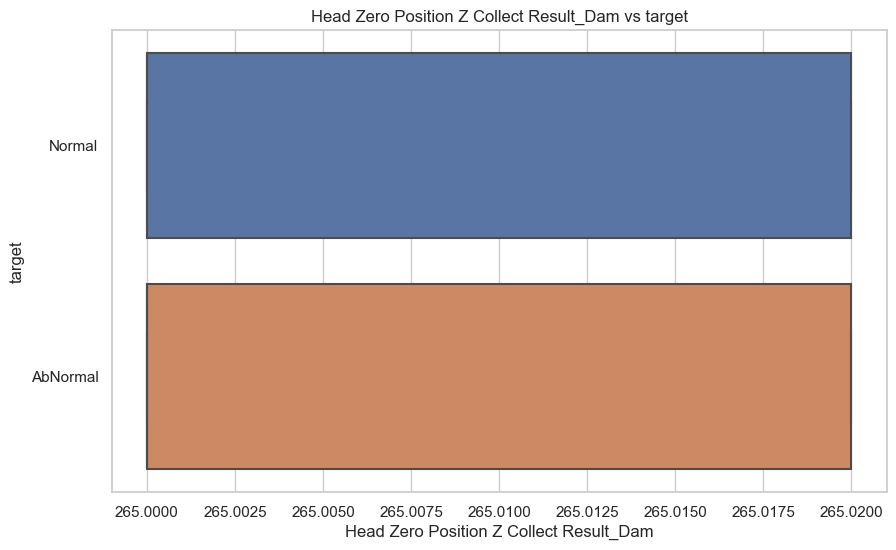

In [649]:
plot_ratio_boxplot(train_data, 'Head Zero Position Z Collect Result_Dam')

In [650]:
# Dam 노즐 zero 위치 Z좌표 드롭
train_data.drop(columns='Head Zero Position Z Collect Result_Dam', inplace=True)
test_data.drop(columns='Head Zero Position Z Collect Result_Dam', inplace=True)

- fill1

In [651]:
# 각 스테이지의 좌표 열 정의
stage1_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1']

stage2_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1']

stage3_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1',
               'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1']

# 거리 계산 함수
def calculate_distances(data):
    data['HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill1'] = np.sqrt(
        (data[stage2_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage2_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage2_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    data['HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill1'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage2_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage2_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage2_cols[2]]) ** 2
    )

    data['HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill1'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    return data

# train_data에 적용
train_data = calculate_distances(train_data)

# test_data에 적용
test_data = calculate_distances(test_data)

In [652]:
# 필요한 열 이름
stage1_stage2_col = 'HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill1'
stage2_stage3_col = 'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill1'
stage1_stage3_col = 'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill1'

# 삼각형의 넓이와 높이를 계산하는 함수
def calculate_triangle_features(data):
    a = data[stage1_stage2_col]
    b = data[stage2_stage3_col]
    c = data[stage1_stage3_col]

    # 헤론의 공식에 따른 삼각형의 넓이 계산
    s = (a + b + c) / 2
    area = np.sqrt(s * (s - a) * (s - b) * (s - c))

    # 높이 계산 (밑변을 c로 가정)
    height = (2 * area) / c

    # 결과를 새로운 열에 저장
    data['HEAD NORMAL DISTANCE_TRIANGLE_area_Fill1'] = area
    data['HEAD NORMAL DISTANCE_TRIANGLE_height_Fill1'] = height

    return data

# train_data에 적용
train_data = calculate_triangle_features(train_data)

# test_data에 적용
test_data = calculate_triangle_features(test_data)

In [653]:
# 제거할 변수 목록
columns_to_drop = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1'

    , 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1'

    , 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1'

    , 'HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill1'
    , 'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill1'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

- fill2

In [654]:
# 각 스테이지의 좌표 열 정의
stage1_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2']

stage2_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2']

stage3_cols = ['HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2',
               'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2']

# 거리 계산 함수
def calculate_distances(data):
    data['HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill2'] = np.sqrt(
        (data[stage2_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage2_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage2_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    data['HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill2'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage2_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage2_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage2_cols[2]]) ** 2
    )

    data['HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill2'] = np.sqrt(
        (data[stage3_cols[0]] - data[stage1_cols[0]]) ** 2 +
        (data[stage3_cols[1]] - data[stage1_cols[1]]) ** 2 +
        (data[stage3_cols[2]] - data[stage1_cols[2]]) ** 2
    )

    return data

# train_data에 적용
train_data = calculate_distances(train_data)

# test_data에 적용
test_data = calculate_distances(test_data)

In [655]:
# 제거할 변수 목록
columns_to_drop = [
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill2'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill2'

    , 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill2'

    , 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill2'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill2'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

### 6. Resin 변수

- dam

In [656]:
# volume*time 파생변수 - Dam
train_data['volume_time_multip_stage1_Dam'] = train_data['Dispense Volume(Stage1) Collect Result_Dam'] * train_data['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam']
train_data['volume_time_multip_stage2_Dam'] = train_data['Dispense Volume(Stage2) Collect Result_Dam'] * train_data['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam']
train_data['volume_time_multip_stage3_Dam'] = train_data['Dispense Volume(Stage3) Collect Result_Dam'] * train_data['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']

train_data['volume_time_multip_avg_Dam'] = (train_data['volume_time_multip_stage1_Dam'] + 
                                            train_data['volume_time_multip_stage2_Dam'] + 
                                            train_data['volume_time_multip_stage3_Dam']) / 3

# volume*time 파생변수 - Dam
test_data['volume_time_multip_stage1_Dam'] = test_data['Dispense Volume(Stage1) Collect Result_Dam'] * test_data['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam']
test_data['volume_time_multip_stage2_Dam'] = test_data['Dispense Volume(Stage2) Collect Result_Dam'] * test_data['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam']
test_data['volume_time_multip_stage3_Dam'] = test_data['Dispense Volume(Stage3) Collect Result_Dam'] * test_data['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam']

test_data['volume_time_multip_avg_Dam'] = (test_data['volume_time_multip_stage1_Dam'] + 
                                            test_data['volume_time_multip_stage2_Dam'] + 
                                            test_data['volume_time_multip_stage3_Dam']) / 3

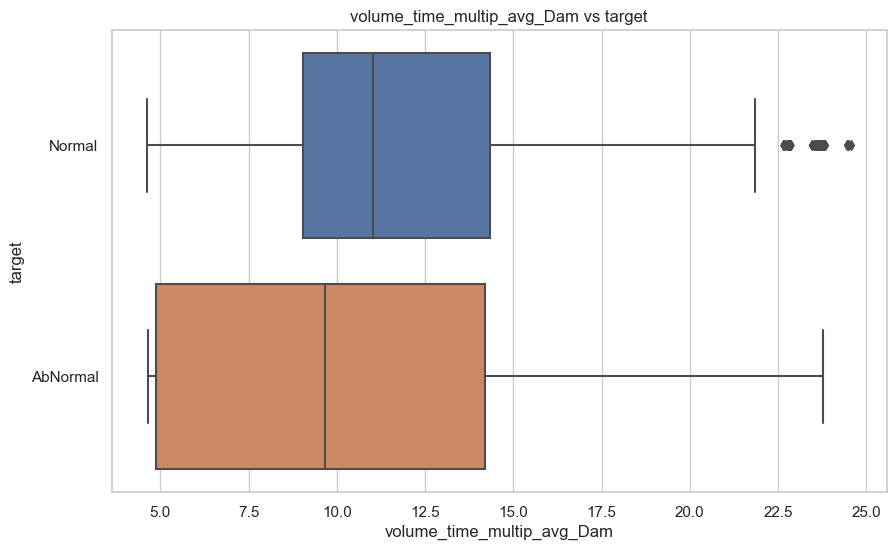

In [657]:
plot_ratio_boxplot(train_data, 'volume_time_multip_avg_Dam')

In [658]:
# 삭제할 열 목록 추가
columns_to_drop = [
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Dam',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Dam',
    'Dispense Volume(Stage1) Collect Result_Dam',
    'Dispense Volume(Stage2) Collect Result_Dam',
    'Dispense Volume(Stage3) Collect Result_Dam',
    #'volume_time_multip_stage1_Dam',
    #'volume_time_multip_stage2_Dam',
    #'volume_time_multip_stage3_Dam'
]

train_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

- fill1

In [659]:
# volume*time 파생변수 - Fill1
train_data['volume_time_multip_stage1_Fill1'] = train_data['Dispense Volume(Stage1) Collect Result_Fill1'] * train_data['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1']
train_data['volume_time_multip_stage2_Fill1'] = train_data['Dispense Volume(Stage2) Collect Result_Fill1'] * train_data['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1']
train_data['volume_time_multip_stage3_Fill1'] = train_data['Dispense Volume(Stage3) Collect Result_Fill1'] * train_data['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']

train_data['volume_time_multip_avg_Fill1'] = (train_data['volume_time_multip_stage1_Fill1'] + 
                                            train_data['volume_time_multip_stage2_Fill1'] + 
                                            train_data['volume_time_multip_stage3_Fill1']) / 3

# volume*time 파생변수 - Fill1
test_data['volume_time_multip_stage1_Fill1'] = test_data['Dispense Volume(Stage1) Collect Result_Fill1'] * test_data['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1']
test_data['volume_time_multip_stage2_Fill1'] = test_data['Dispense Volume(Stage2) Collect Result_Fill1'] * test_data['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1']
test_data['volume_time_multip_stage3_Fill1'] = test_data['Dispense Volume(Stage3) Collect Result_Fill1'] * test_data['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']

test_data['volume_time_multip_avg_Fill1'] = (test_data['volume_time_multip_stage1_Fill1'] + 
                                            test_data['volume_time_multip_stage2_Fill1'] + 
                                            test_data['volume_time_multip_stage3_Fill1']) / 3

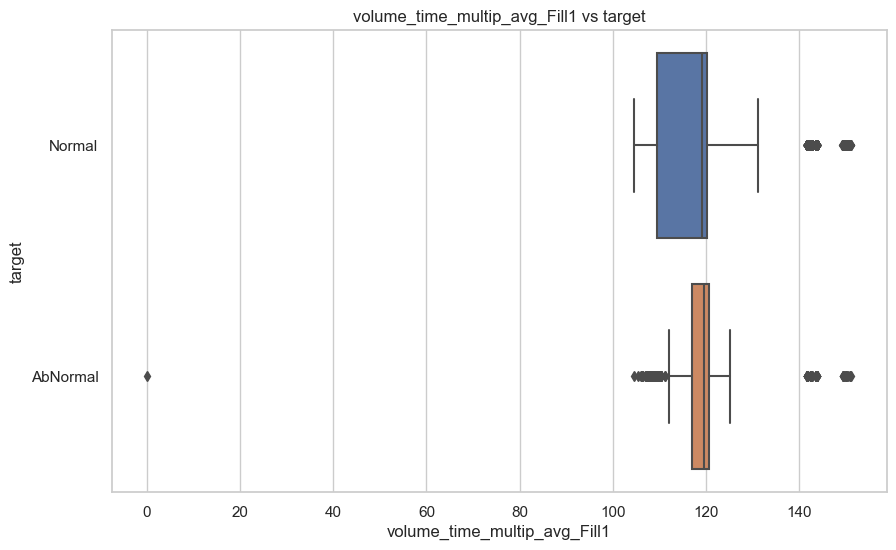

In [660]:
plot_ratio_boxplot(train_data, 'volume_time_multip_avg_Fill1')

In [661]:
# 삭제할 열 목록 추가
columns_to_drop = [
    'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1',
    'DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1',
    'DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1',
    'Dispense Volume(Stage1) Collect Result_Fill1',
    'Dispense Volume(Stage2) Collect Result_Fill1',
    'Dispense Volume(Stage3) Collect Result_Fill1',
    #'volume_time_multip_stage1_Fill1',
    #'volume_time_multip_stage2_Fill1',
    #'volume_time_multip_stage3_Fill1'
]

train_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

### 7. Circle, Line 변수

In [662]:
### circle
# 열 이름 변경
train_data.rename(columns={
    'Stage1 Circle1 Distance Speed Collect Result_Dam': 'Stage1_Circle_Distance_Speed_Dam',
    'Stage2 Circle1 Distance Speed Collect Result_Dam': 'Stage2_Circle_Distance_Speed_Dam',
    'Stage3 Circle1 Distance Speed Collect Result_Dam': 'Stage3_Circle_Distance_Speed_Dam'
}, inplace=True)

test_data.rename(columns={
    'Stage1 Circle1 Distance Speed Collect Result_Dam': 'Stage1_Circle_Distance_Speed_Dam',
    'Stage2 Circle1 Distance Speed Collect Result_Dam': 'Stage2_Circle_Distance_Speed_Dam',
    'Stage3 Circle1 Distance Speed Collect Result_Dam': 'Stage3_Circle_Distance_Speed_Dam'
}, inplace=True)

In [663]:
summarize_group(train_data, ['Stage1_Circle_Distance_Speed_Dam'
                             , 'Stage2_Circle_Distance_Speed_Dam'
                             , 'Stage3_Circle_Distance_Speed_Dam'
                           # , 'Equipment_num'
                             ])

Grouped by: Stage1_Circle_Distance_Speed_Dam, Stage2_Circle_Distance_Speed_Dam, Stage3_Circle_Distance_Speed_Dam

                  group  'AdNormal' count     ratio  Total
0    (4000, 4000, 4000)               164  0.040918   4008
1    (4000, 5000, 4000)                57  0.042191   1351
2    (4000, 8000, 4000)                28  0.063636    440
3    (4000, 9000, 4000)                 7  0.020649    339
4    (5000, 9000, 5000)               305  0.062232   4901
5    (5800, 5300, 5800)               269  0.050803   5295
6    (6000, 5500, 6000)                65  0.048435   1342
7    (6200, 5500, 6200)                15  0.052817    284
8    (6500, 5500, 6000)                 5  0.061728     81
9    (6500, 5500, 6500)               149  0.034300   4344
10   (6500, 6000, 6500)                 3  0.083333     36
11   (6500, 6500, 6500)               435  0.054152   8033
12  (6500, 12000, 6500)                 3  0.066667     45
13   (9000, 9000, 9000)               548  0.083245   6583
1

<Figure size 1000x500 with 0 Axes>

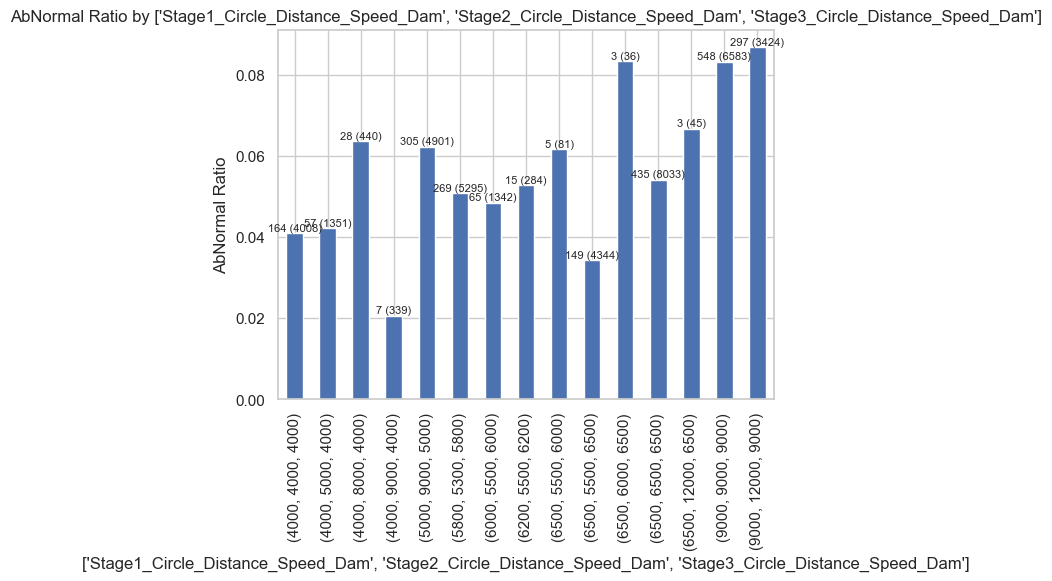

In [664]:
plot_ratio(train_data, ['Stage1_Circle_Distance_Speed_Dam'
                             , 'Stage2_Circle_Distance_Speed_Dam'
                             , 'Stage3_Circle_Distance_Speed_Dam'
                           # , 'Equipment_num'
                             ])

In [665]:
# 제거할 변수 목록
columns_to_drop = [
    'Stage1 Circle2 Distance Speed Collect Result_Dam',
    'Stage1 Circle3 Distance Speed Collect Result_Dam',
    'Stage1 Circle4 Distance Speed Collect Result_Dam',
    
    'Stage2 Circle2 Distance Speed Collect Result_Dam',
    'Stage2 Circle3 Distance Speed Collect Result_Dam',
    'Stage2 Circle4 Distance Speed Collect Result_Dam',
    
    'Stage3 Circle2 Distance Speed Collect Result_Dam',
    'Stage3 Circle3 Distance Speed Collect Result_Dam',
    'Stage3 Circle4 Distance Speed Collect Result_Dam'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

In [666]:
### line
# line1&3과 line2&4를 합친 파생변수 생성 함수
def check_distance_speed(data, stage):
    # 단계에 따라 라인 번호 정의
    line_pairs = [(1, 3), (2, 4)]
    
    # 각 라인 쌍에 대해 반복
    for line1, line2 in line_pairs:
        line1_name = f'Stage{stage} Line{line1} Distance Speed Collect Result_Dam'
        line2_name = f'Stage{stage} Line{line2} Distance Speed Collect Result_Dam'
        
        # 새로운 열 이름 설정
        new_col_name = f'stage{stage}_line{line1}{line2}_distance_speed_Dam'
        
        # 조건에 따라 값 설정
        data[new_col_name] = data.apply(
            lambda row: row[line1_name] if row[line1_name] == row[line2_name] else 'diff', axis=1
        )

# train_data와 test_data 모두에 대해 함수 호출
for stage in range(1, 4):
    check_distance_speed(train_data, stage)
    check_distance_speed(test_data, stage)

In [109]:
# train_data에서 변수들을 object 타입으로 변환
train_data['stage1_line24_distance_speed_Dam'] = train_data['stage1_line24_distance_speed_Dam'].astype(object)
train_data['stage2_line24_distance_speed_Dam'] = train_data['stage2_line24_distance_speed_Dam'].astype(object)
train_data['stage3_line24_distance_speed_Dam'] = train_data['stage3_line24_distance_speed_Dam'].astype(object)

# test_data에서 변수들을 object 타입으로 변환
test_data['stage1_line24_distance_speed_Dam'] = test_data['stage1_line24_distance_speed_Dam'].astype(object)
test_data['stage2_line24_distance_speed_Dam'] = test_data['stage2_line24_distance_speed_Dam'].astype(object)
test_data['stage3_line24_distance_speed_Dam'] = test_data['stage3_line24_distance_speed_Dam'].astype(object)

In [110]:
# 제거할 변수 목록
columns_to_drop = [
    'Stage1 Line1 Distance Speed Collect Result_Dam',
    'Stage1 Line2 Distance Speed Collect Result_Dam',
    'Stage1 Line3 Distance Speed Collect Result_Dam',
    'Stage1 Line4 Distance Speed Collect Result_Dam',
    
    'Stage2 Line1 Distance Speed Collect Result_Dam',
    'Stage2 Line2 Distance Speed Collect Result_Dam',
    'Stage2 Line3 Distance Speed Collect Result_Dam',
    'Stage2 Line4 Distance Speed Collect Result_Dam',
    
    'Stage3 Line1 Distance Speed Collect Result_Dam',
    'Stage3 Line2 Distance Speed Collect Result_Dam',
    'Stage3 Line3 Distance Speed Collect Result_Dam',
    'Stage3 Line4 Distance Speed Collect Result_Dam'
]

# 변수 제거
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

### 8. Thickness 변수

In [111]:
# 세 개 컬럼의 평균을 계산하여 새로운 컬럼 생성
train_data['average_thickness_Dam'] = train_data[['THICKNESS 1 Collect Result_Dam', 
                                                  'THICKNESS 2 Collect Result_Dam', 
                                                  'THICKNESS 3 Collect Result_Dam']].mean(axis=1)

test_data['average_thickness_Dam'] = test_data[['THICKNESS 1 Collect Result_Dam', 
                                                'THICKNESS 2 Collect Result_Dam', 
                                                'THICKNESS 3 Collect Result_Dam']].mean(axis=1)

<Figure size 1000x500 with 0 Axes>

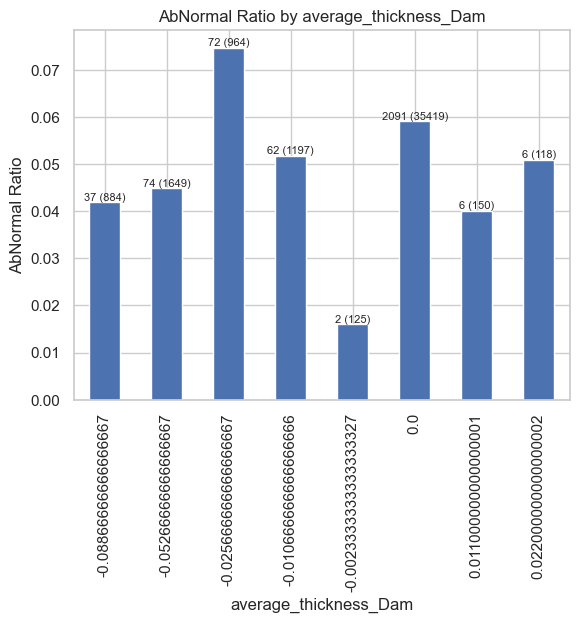

In [112]:
plot_ratio(train_data, 'average_thickness_Dam')

<Figure size 1000x500 with 0 Axes>

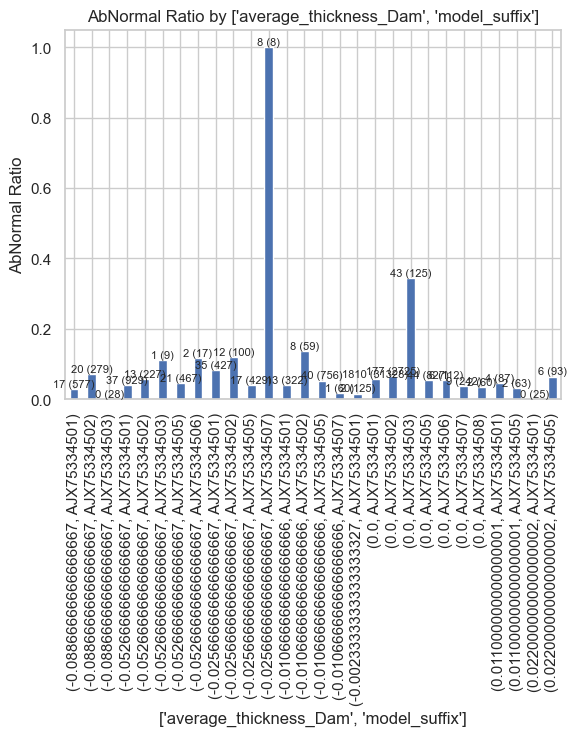

In [113]:
plot_ratio(train_data, ['average_thickness_Dam'
                        , 'model_suffix'])

In [692]:
# 삭제할 컬럼 리스트
columns_to_drop = [
    'THICKNESS 1 Collect Result_Dam',
    'THICKNESS 2 Collect Result_Dam',
    'THICKNESS 3 Collect Result_Dam'
]

# 지정한 컬럼 삭제
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

### 9. Autoclave 관련 변수

In [693]:
# 각 압력과 시간의 곱을 담은 새로운 컬럼 생성
train_data['1st_pressure_time_AutoClave'] = train_data['1st Pressure Collect Result_AutoClave'] * train_data['1st Pressure 1st Pressure Unit Time_AutoClave']
train_data['2nd_pressure_time_AutoClave'] = train_data['2nd Pressure Collect Result_AutoClave'] * train_data['2nd Pressure Unit Time_AutoClave']
train_data['3rd_pressure_time_AutoClave'] = train_data['3rd Pressure Collect Result_AutoClave'] * train_data['3rd Pressure Unit Time_AutoClave']

train_data['avg_pressure_time_AutoClave'] = (train_data['1st_pressure_time_AutoClave'] +
                                             train_data['2nd_pressure_time_AutoClave'] +
                                             train_data['3rd_pressure_time_AutoClave']) / 3

In [694]:
# 각 압력과 시간의 곱을 담은 새로운 컬럼 생성
test_data['1st_pressure_time_AutoClave'] = test_data['1st Pressure Collect Result_AutoClave'] * test_data['1st Pressure 1st Pressure Unit Time_AutoClave']
test_data['2nd_pressure_time_AutoClave'] = test_data['2nd Pressure Collect Result_AutoClave'] * test_data['2nd Pressure Unit Time_AutoClave']
test_data['3rd_pressure_time_AutoClave'] = test_data['3rd Pressure Collect Result_AutoClave'] * test_data['3rd Pressure Unit Time_AutoClave']

test_data['avg_pressure_time_AutoClave'] = (test_data['1st_pressure_time_AutoClave'] +
                                             test_data['2nd_pressure_time_AutoClave'] +
                                             test_data['3rd_pressure_time_AutoClave']) / 3

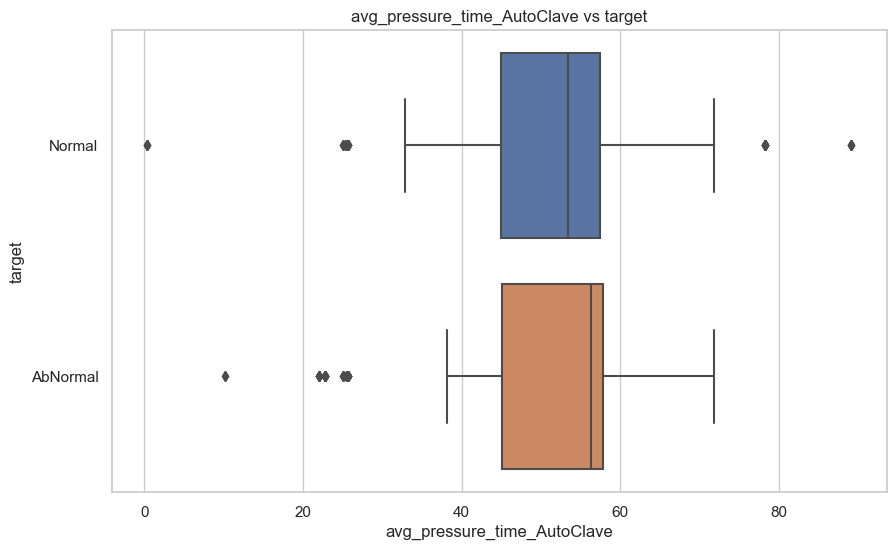

In [695]:
plot_ratio_boxplot(train_data, 'avg_pressure_time_AutoClave')

In [696]:
# 삭제할 컬럼 리스트
columns_to_drop = [
    '1st Pressure Collect Result_AutoClave',
    '1st Pressure 1st Pressure Unit Time_AutoClave',
    '2nd Pressure Collect Result_AutoClave',
    '2nd Pressure Unit Time_AutoClave',
    '3rd Pressure Collect Result_AutoClave',
    '3rd Pressure Unit Time_AutoClave',
]

# 지정한 컬럼 삭제
train_data.drop(columns=columns_to_drop, inplace=True)
test_data.drop(columns=columns_to_drop, inplace=True)

### 10. Time 변수

In [697]:
# 총시간 대비 비율 변수
def calculate_total_time_and_ratios(data):
    data['total_time'] = (
        data['Machine Tact time Collect Result_Dam'] +
        data['Machine Tact time Collect Result_Fill1'] +
        data['Machine Tact time Collect Result_Fill2'] +
        data['Chamber Temp. Unit Time_AutoClave']
    )
    data['time_ratio_Dam'] = (data['Machine Tact time Collect Result_Dam'] / data['total_time']).round(3)
    data['time_ratio_Fill1'] = (data['Machine Tact time Collect Result_Fill1'] / data['total_time']).round(3)
    data['time_ratio_Fill2'] = (data['Machine Tact time Collect Result_Fill2'] / data['total_time']).round(3)
    data['time_ratio_AutoClave'] = (data['Chamber Temp. Unit Time_AutoClave'] / data['total_time']).round(3)
    return data

# train_data와 test_data에 함수 적용
train_data = calculate_total_time_and_ratios(train_data)
test_data = calculate_total_time_and_ratios(test_data)

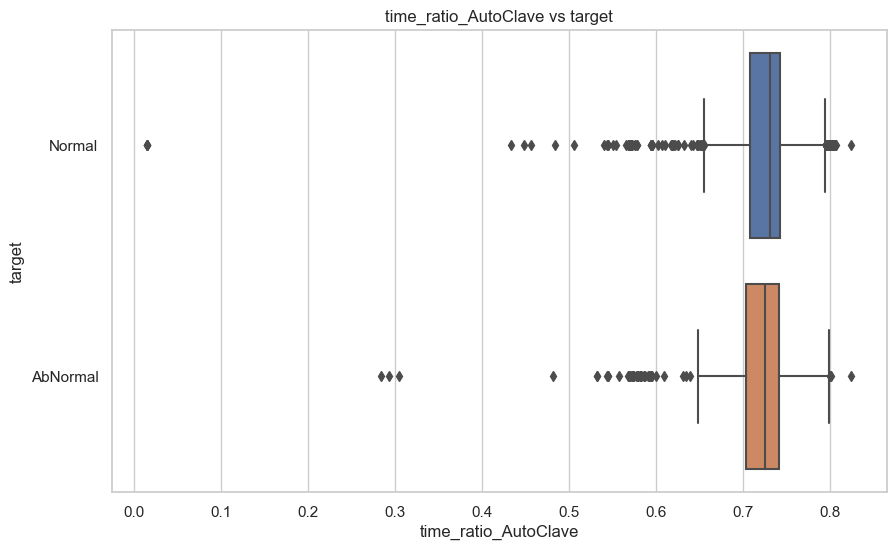

In [698]:
plot_ratio_boxplot(train_data, 'time_ratio_AutoClave')

In [699]:
# 변수 제거
train_data.drop(columns=[
    'total_time'
    , 'Machine Tact time Collect Result_Dam'
    , 'Machine Tact time Collect Result_Fill1'
    , 'Machine Tact time Collect Result_Fill2'
    , 'Chamber Temp. Unit Time_AutoClave'], inplace=True)

test_data.drop(columns=[
    'total_time'
    , 'Machine Tact time Collect Result_Dam'
    , 'Machine Tact time Collect Result_Fill1'
    , 'Machine Tact time Collect Result_Fill2'
    , 'Chamber Temp. Unit Time_AutoClave'], inplace=True)

### 11. 변수 확인

In [700]:
# 삭제할 변수 리스트
columns_to_drop = [
    'Chamber Temp. Judge Value_AutoClave', 
    'GMES_ORIGIN_INSP_JUDGE_CODE Collect Result_AutoClave', 
    'GMES_ORIGIN_INSP_JUDGE_CODE Judge Value_AutoClave'
]

train_data = train_data.drop(columns=columns_to_drop)
test_data = test_data.drop(columns=columns_to_drop)

In [701]:
# 값의 종류가 1개이고 결측값이 없는 열을 제거하는 함수
def drop_single_value_columns(df):
    cols_to_drop = [col for col in df.columns if col != 'target' and df[col].nunique() == 1 and df[col].isnull().sum() == 0]
    df_dropped = df.drop(columns=cols_to_drop)
    return df_dropped, cols_to_drop

# train_data와 test_data에서 해당 열 제거 및 삭제된 열 이름과 개수 출력
train_data, train_cols_dropped = drop_single_value_columns(train_data)
test_data, test_cols_dropped = drop_single_value_columns(test_data)

# print("삭제된 train_data 열 이름:", train_cols_dropped)
print("삭제된 train_data 열 개수:", len(train_cols_dropped))

# print("삭제된 test_data 열 이름:", test_cols_dropped)
print("삭제된 test_data 열 개수:", len(test_cols_dropped))

삭제된 train_data 열 개수: 37
삭제된 test_data 열 개수: 37


### 12. target encoding

In [702]:
# object 타입의 변수 출력
train_object_columns = train_data.select_dtypes(include=['object']).columns
test_object_columns = test_data.select_dtypes(include=['object']).columns

print(train_object_columns, f" train_object_columns 갯수 : {len(train_object_columns)}")
print(test_object_columns, f" test_object_columns 갯수 : {len(test_object_columns)}")

# 각 object 변수의 고유 값 개수 출력
print("\nTrain Data:")
for col in train_object_columns:
    unique_count = train_data[col].nunique()
    print(f"{col} unique 값 갯수: {unique_count}")

print("\nTest Data:")
for col in test_object_columns:
    unique_count = test_data[col].nunique()
    print(f"{col} unique 값 갯수: {unique_count}")

Index(['model_suffix', 'target', 'Receip_No', 'cleaned_workorder',
       'Equipment_num', 'PalletID_Collect_Result',
       'cure_end_position_XZ_Fill2', 'cure_start_position_XZ_Fill2',
       'cure_standby_position_XZ_Fill2', 'stage1_line13_distance_speed_Dam',
       'stage1_line24_distance_speed_Dam', 'stage2_line13_distance_speed_Dam',
       'stage2_line24_distance_speed_Dam', 'stage3_line13_distance_speed_Dam',
       'stage3_line24_distance_speed_Dam'],
      dtype='object')  train_object_columns 갯수 : 15
Index(['Set ID', 'model_suffix', 'Receip_No', 'cleaned_workorder',
       'Equipment_num', 'PalletID_Collect_Result',
       'cure_end_position_XZ_Fill2', 'cure_start_position_XZ_Fill2',
       'cure_standby_position_XZ_Fill2', 'stage1_line13_distance_speed_Dam',
       'stage1_line24_distance_speed_Dam', 'stage2_line13_distance_speed_Dam',
       'stage2_line24_distance_speed_Dam', 'stage3_line13_distance_speed_Dam',
       'stage3_line24_distance_speed_Dam'],
      dtype='obj

In [703]:
# 전체 평균 타겟 값 계산 (abnormal 전체 비율)
train_data['target_01'] = train_data['target'].apply(lambda x: 1 if x == 'AbNormal' else 0)
global_mean = train_data['target_01'].mean()

In [704]:
# 적용할 열 리스트
columns_to_encode = [
    'Receip_No',
    'model_suffix',
    'cleaned_workorder',
    'PalletID_Collect_Result',
    'cure_end_position_XZ_Fill2',
    'cure_start_position_XZ_Fill2',
    'cure_standby_position_XZ_Fill2',
    'stage1_line13_distance_speed_Dam',
    'stage1_line24_distance_speed_Dam',
    'stage2_line13_distance_speed_Dam',
    'stage2_line24_distance_speed_Dam',
    'stage3_line13_distance_speed_Dam',
    'stage3_line24_distance_speed_Dam',
    # 추가
    'Equipment_num',                             
    'Production_Qty_Collect_Result'    

        
]

# 전체 데이터의 평균 타겟값
global_mean = train_data['target_01'].mean()

for column in columns_to_encode:
    # 각 column에 대한 평균 타겟값과 카운트 계산
    target_mean = train_data.groupby(column)['target_01'].mean()
    count = train_data.groupby(column)['target_01'].count()

    # 스무딩 적용
    '''
    추천 알파 값:
    0.5: 일반적으로 많이 사용되는 값으로, 기존 데이터와 전체 평균 간의 균형을 잘 맞춰줍니다.
    0.3: 데이터가 충분히 많고 각 카테고리의 타겟 값이 잘 분포되어 있을 때 사용.
    0.7: 데이터가 적거나 특정 카테고리가 상대적으로 적을 때 사용.
    '''
    alpha = 0.5
    smoothed_values = (target_mean * count + global_mean * alpha) / (count + alpha)

    # 인코딩된 값을 데이터프레임에 추가
    train_data[f'{column}_encoded'] = train_data[column].map(smoothed_values)

    # test_data에 동일한 인코딩 값을 추가
    encoding_dict = train_data.groupby(column)[f'{column}_encoded'].first().to_dict()
    test_data[f'{column}_encoded'] = test_data[column].map(encoding_dict)

In [705]:
# 삭제할 열 리스트
columns_to_drop = [
    'target_01',
    'Receip_No',
    'model_suffix',
    'cleaned_workorder',
    'PalletID_Collect_Result',
    'cure_end_position_XZ_Fill2',
    'cure_start_position_XZ_Fill2',
    'cure_standby_position_XZ_Fill2',
    'stage1_line13_distance_speed_Dam',
    'stage1_line24_distance_speed_Dam',
    'stage2_line13_distance_speed_Dam',
    'stage2_line24_distance_speed_Dam',
    'stage3_line13_distance_speed_Dam',
    'stage3_line24_distance_speed_Dam',
    # 추가
    'Equipment_num',                             
    'Production_Qty_Collect_Result'    
]

# train_data와 test_data에서 열 드랍
train_data = train_data.drop(columns=columns_to_drop, errors='ignore')
test_data = test_data.drop(columns=columns_to_drop, errors='ignore')

In [706]:
# target 열을 제외한 나머지 열의 결측치를 0.05로 채우기
test_data.fillna(value={col: 0.05 for col in test_data.columns if col != 'target'}, inplace=True)

In [707]:
# info 잘리지 않게 출력
train_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 58 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   CURE SPEED Collect Result_Dam                   40506 non-null  int64  
 1   DISCHARGED SPEED OF RESIN Collect Result_Dam    40506 non-null  int64  
 2   Head Clean Position Z Collect Result_Dam        40506 non-null  float64
 3   Head Purge Position Z Collect Result_Dam        40506 non-null  float64
 4   Head Zero Position Y Collect Result_Dam         40506 non-null  float64
 5   Stage1_Circle_Distance_Speed_Dam                40506 non-null  int64  
 6   Stage2_Circle_Distance_Speed_Dam                40506 non-null  int64  
 7   Stage3_Circle_Distance_Speed_Dam                40506 non-null  int64  
 8   WorkMode Collect Result                         40506 non-null  float64
 9   Chamber Temp. Collect Result_AutoClave 

In [1152]:
# info 잘리지 않게 출력
test_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17361 entries, 0 to 17360
Data columns (total 58 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Set ID                                          17361 non-null  object 
 1   CURE SPEED Collect Result_Dam                   17361 non-null  int64  
 2   DISCHARGED SPEED OF RESIN Collect Result_Dam    17361 non-null  int64  
 3   Head Clean Position Z Collect Result_Dam        17361 non-null  float64
 4   Head Purge Position Z Collect Result_Dam        17361 non-null  float64
 5   Head Zero Position Y Collect Result_Dam         17361 non-null  float64
 6   Stage1_Circle_Distance_Speed_Dam                17361 non-null  int64  
 7   Stage2_Circle_Distance_Speed_Dam                17361 non-null  int64  
 8   Stage3_Circle_Distance_Speed_Dam                17361 non-null  int64  
 9   WorkMode Collect Result                

### 13. correlation

In [1153]:
# dam, fill1, fill2 공통 변수
var_dam_fill = [
    'Receip_No_encoded',
    'Equipment_num_encoded',
    'PalletID_Collect_Result_encoded',
    'Production_Qty_Collect_Result_encoded',
    'WorkMode Collect Result'
]

In [1154]:
# 전체 공통 변수
### correlation 확인을 위한 변수 리스트
var_all_corr = [
    'model_suffix_encoded',
    'cleaned_workorder_encoded'
]

### train
var_all_train = [
    'target',
    'model_suffix_encoded',
    'cleaned_workorder_encoded'
]

### test
var_all_test = [
    'Set ID',
    'target',
    'model_suffix_encoded',
    'cleaned_workorder_encoded'
]

- dam

In [1155]:
# 상관관계를 확인할 데이터셋
combined_variables = var_dam_fill + var_all_corr + [var for var in train_data.columns if '_Dam' in var]
combined_variables

['Receip_No_encoded',
 'Equipment_num_encoded',
 'PalletID_Collect_Result_encoded',
 'Production_Qty_Collect_Result_encoded',
 'WorkMode Collect Result',
 'model_suffix_encoded',
 'cleaned_workorder_encoded',
 'CURE SPEED Collect Result_Dam',
 'DISCHARGED SPEED OF RESIN Collect Result_Dam',
 'Head Clean Position Z Collect Result_Dam',
 'Head Purge Position Z Collect Result_Dam',
 'Head Zero Position Y Collect Result_Dam',
 'Stage1_Circle_Distance_Speed_Dam',
 'Stage2_Circle_Distance_Speed_Dam',
 'Stage3_Circle_Distance_Speed_Dam',
 'CURE_DISTANCE_Dam',
 'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam',
 'HEAD NORMAL DISTANCE_TRIANGLE_area_Dam',
 'HEAD NORMAL DISTANCE_TRIANGLE_height_Dam',
 'volume_time_multip_stage1_Dam',
 'volume_time_multip_stage2_Dam',
 'volume_time_multip_stage3_Dam',
 'volume_time_multip_avg_Dam',
 'average_thickness_Dam',
 'time_ratio_Dam',
 'stage1_line13_distance_speed_Dam_encoded',
 'stage1_line24_distance_speed_Dam_encoded',
 'stage2_line13_distance_speed_Dam_encoded

In [1159]:
variables = ['Receip_No_encoded',
 'Equipment_num_encoded',   
 'PalletID_Collect_Result_encoded',
 'Production_Qty_Collect_Result_encoded',
 'WorkMode Collect Result',
 'model_suffix_encoded',
 'cleaned_workorder_encoded',
 'CURE SPEED Collect Result_Dam',
 'DISCHARGED SPEED OF RESIN Collect Result_Dam',
 'Head Clean Position Z Collect Result_Dam',
 'Head Purge Position Z Collect Result_Dam',
 'Head Zero Position Y Collect Result_Dam',
#  'Stage1_Circle_Distance_Speed_Dam',
 'Stage2_Circle_Distance_Speed_Dam',
 #'Stage3_Circle_Distance_Speed_Dam',
 'CURE_DISTANCE_Dam',
 #'HEAD NORMAL DISTANCE_TRIANGLE_area_Dam',
 'HEAD NORMAL DISTANCE_TRIANGLE_height_Dam',
 'volume_time_multip_stage1_Dam',
 'volume_time_multip_stage2_Dam',
 #'volume_time_multip_stage3_Dam',
 #'volume_time_multip_avg_Dam',
 'average_thickness_Dam',
 'time_ratio_Dam',
 #'stage1_line13_distance_speed_Dam_encoded',
 'stage1_line24_distance_speed_Dam_encoded',
 #'stage2_line13_distance_speed_Dam_encoded',
 'stage2_line24_distance_speed_Dam_encoded',
 #'stage3_line13_distance_speed_Dam_encoded',
 #'stage3_line24_distance_speed_Dam_encoded',
 'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Dam']

# 변수들로만 이루어진 DataFrame 생성
filtered_data = train_data[variables]

In [1160]:
# 자기자신을 제외하고 상관관계 절댓값이 0.9 이상인 조합 찾기
correlation_matrix = filtered_data.corr()
strong_correlations = correlation_matrix[(correlation_matrix.abs() >= 0.9) & (correlation_matrix != 1)]

# 리스트로 변환
strong_correlations_pairs = strong_correlations.stack().reset_index()
strong_correlations_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

# 결과 출력
print(strong_correlations_pairs)

Empty DataFrame
Columns: [Variable 1, Variable 2, Correlation]
Index: []


In [1161]:
# 드랍할 열 목록
columns_to_drop = [
    'Stage1_Circle_Distance_Speed_Dam',
    'Stage3_Circle_Distance_Speed_Dam',
    'HEAD NORMAL DISTANCE_TRIANGLE_area_Dam',
    'stage1_line24_distance_speed_Dam_encoded',
    'stage2_line13_distance_speed_Dam_encoded',
    'stage3_line13_distance_speed_Dam_encoded',
    'stage3_line24_distance_speed_Dam_encoded',
    'volume_time_multip_stage3_Dam',
    'volume_time_multip_avg_Dam'
]

# 열 삭제
train_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [1162]:
# '_Dam'을 포함하는 변수 선택
dam_variables = [var for var in train_data.columns if '_Dam' in var]

# train
final_columns_train = var_dam_fill + var_all_train + dam_variables
train_data_dam = train_data[final_columns_train]

# test 
final_columns_test = var_dam_fill + var_all_test + dam_variables
test_data_dam = test_data[final_columns_test]

In [1163]:
train_data_dam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 23 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Receip_No_encoded                             40506 non-null  float64
 1   Equipment_num_encoded                         40506 non-null  float64
 2   PalletID_Collect_Result_encoded               40506 non-null  float64
 3   Production_Qty_Collect_Result_encoded         40506 non-null  float64
 4   WorkMode Collect Result                       40506 non-null  float64
 5   target                                        40506 non-null  object 
 6   model_suffix_encoded                          40506 non-null  float64
 7   cleaned_workorder_encoded                     40506 non-null  float64
 8   CURE SPEED Collect Result_Dam                 40506 non-null  int64  
 9   DISCHARGED SPEED OF RESIN Collect Result_Dam  40506 non-null 

In [1164]:
test_data_dam.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17361 entries, 0 to 17360
Data columns (total 24 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Receip_No_encoded                             17361 non-null  float64
 1   Equipment_num_encoded                         17361 non-null  float64
 2   PalletID_Collect_Result_encoded               17361 non-null  float64
 3   Production_Qty_Collect_Result_encoded         17361 non-null  float64
 4   WorkMode Collect Result                       17361 non-null  float64
 5   Set ID                                        17361 non-null  object 
 6   target                                        0 non-null      float64
 7   model_suffix_encoded                          17361 non-null  float64
 8   cleaned_workorder_encoded                     17361 non-null  float64
 9   CURE SPEED Collect Result_Dam                 17361 non-null 

- fill1

In [1165]:
# 상관관계를 확인할 데이터셋
combined_variables = var_dam_fill + var_all_corr + [var for var in train_data.columns if '_Fill1' in var]
combined_variables

['Receip_No_encoded',
 'Equipment_num_encoded',
 'PalletID_Collect_Result_encoded',
 'Production_Qty_Collect_Result_encoded',
 'WorkMode Collect Result',
 'model_suffix_encoded',
 'cleaned_workorder_encoded',
 'DISCHARGED SPEED OF RESIN Collect Result_Fill1',
 'Head Purge Position Z Collect Result_Fill1',
 'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill1',
 'HEAD NORMAL DISTANCE_TRIANGLE_area_Fill1',
 'HEAD NORMAL DISTANCE_TRIANGLE_height_Fill1',
 'volume_time_multip_stage1_Fill1',
 'volume_time_multip_stage2_Fill1',
 'volume_time_multip_stage3_Fill1',
 'volume_time_multip_avg_Fill1',
 'time_ratio_Fill1']

In [1166]:
variables = ['Receip_No_encoded',
 'Equipment_num_encoded',   
 'PalletID_Collect_Result_encoded',
 'Production_Qty_Collect_Result_encoded',
 'WorkMode Collect Result',
 'model_suffix_encoded',
 'cleaned_workorder_encoded',
 'DISCHARGED SPEED OF RESIN Collect Result_Fill1',
 'Head Purge Position Z Collect Result_Fill1',
 'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill1',
 #'HEAD NORMAL DISTANCE_TRIANGLE_area_Fill1',
 'HEAD NORMAL DISTANCE_TRIANGLE_height_Fill1',
 #'volume_time_multip_avg_Fill1',
 'volume_time_multip_stage1_Fill1',
 #'volume_time_multip_stage2_Fill1',
 #'volume_time_multip_stage3_Fill1',
 'time_ratio_Fill1']

# 변수들로만 이루어진 DataFrame 생성
filtered_data = train_data[variables]

In [1167]:
# 자기자신을 제외하고 상관관계 절댓값이 0.9 이상인 조합 찾기
correlation_matrix = filtered_data.corr()
strong_correlations = correlation_matrix[(correlation_matrix.abs() >= 0.9) & (correlation_matrix != 1)]

# 리스트로 변환
strong_correlations_pairs = strong_correlations.stack().reset_index()
strong_correlations_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

# 결과 출력
print(strong_correlations_pairs)

Empty DataFrame
Columns: [Variable 1, Variable 2, Correlation]
Index: []


In [1168]:
# 드랍할 열 목록
columns_to_drop = [
    'HEAD NORMAL DISTANCE_TRIANGLE_area_Fill1',
    'volume_time_multip_avg_Fill1',
    'volume_time_multip_stage2_Fill1',
    'volume_time_multip_stage3_Fill1'
]

# 열 삭제
train_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [1169]:
# '_Fill1'을 포함하는 변수 선택
fill1_variables = [var for var in train_data.columns if '_Fill1' in var]

# train
final_columns_train = var_dam_fill + var_all_train + fill1_variables
train_data_fill1 = train_data[final_columns_train]

# test 
final_columns_test = var_dam_fill + var_all_test + fill1_variables
test_data_fill1 = test_data[final_columns_test]

In [1170]:
train_data_fill1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 14 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Receip_No_encoded                               40506 non-null  float64
 1   Equipment_num_encoded                           40506 non-null  float64
 2   PalletID_Collect_Result_encoded                 40506 non-null  float64
 3   Production_Qty_Collect_Result_encoded           40506 non-null  float64
 4   WorkMode Collect Result                         40506 non-null  float64
 5   target                                          40506 non-null  object 
 6   model_suffix_encoded                            40506 non-null  float64
 7   cleaned_workorder_encoded                       40506 non-null  float64
 8   DISCHARGED SPEED OF RESIN Collect Result_Fill1  40506 non-null  float64
 9   Head Purge Position Z Collect Result_Fi

In [1171]:
test_data_fill1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17361 entries, 0 to 17360
Data columns (total 15 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Receip_No_encoded                               17361 non-null  float64
 1   Equipment_num_encoded                           17361 non-null  float64
 2   PalletID_Collect_Result_encoded                 17361 non-null  float64
 3   Production_Qty_Collect_Result_encoded           17361 non-null  float64
 4   WorkMode Collect Result                         17361 non-null  float64
 5   Set ID                                          17361 non-null  object 
 6   target                                          0 non-null      float64
 7   model_suffix_encoded                            17361 non-null  float64
 8   cleaned_workorder_encoded                       17361 non-null  float64
 9   DISCHARGED SPEED OF RESIN Collect Resul

- fill2

In [1172]:
# 상관관계를 확인할 데이터셋
combined_variables = var_dam_fill + var_all_corr + [var for var in train_data.columns if '_Fill2' in var]
combined_variables

['Receip_No_encoded',
 'Equipment_num_encoded',
 'PalletID_Collect_Result_encoded',
 'Production_Qty_Collect_Result_encoded',
 'WorkMode Collect Result',
 'model_suffix_encoded',
 'cleaned_workorder_encoded',
 'CURE SPEED Collect Result_Fill2',
 'Head Purge Position Z Collect Result_Fill2',
 'HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill2',
 'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill2',
 'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill2',
 'time_ratio_Fill2',
 'cure_end_position_XZ_Fill2_encoded',
 'cure_start_position_XZ_Fill2_encoded',
 'cure_standby_position_XZ_Fill2_encoded']

In [1173]:
variables = ['Receip_No_encoded',
 'Equipment_num_encoded',   
 'PalletID_Collect_Result_encoded',
 'Production_Qty_Collect_Result_encoded',
 'WorkMode Collect Result',
 'model_suffix_encoded',
 'cleaned_workorder_encoded',
 'CURE SPEED Collect Result_Fill2',
 'Head Purge Position Z Collect Result_Fill2',
 'HEAD NORMAL DISTANCE_STAGE1_STAGE2_Fill2',
 #'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill2',
 #'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill2',
 'time_ratio_Fill2',
 'cure_end_position_XZ_Fill2_encoded',
 'cure_start_position_XZ_Fill2_encoded']
 #'cure_standby_position_XZ_Fill2_encoded']

# 변수들로만 이루어진 DataFrame 생성
filtered_data = train_data[variables]

In [1174]:
# 자기자신을 제외하고 상관관계 절댓값이 0.9 이상인 조합 찾기
correlation_matrix = filtered_data.corr()
strong_correlations = correlation_matrix[(correlation_matrix.abs() >= 0.9) & (correlation_matrix != 1)]

# 리스트로 변환
strong_correlations_pairs = strong_correlations.stack().reset_index()
strong_correlations_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

# 결과 출력
print(strong_correlations_pairs)

Empty DataFrame
Columns: [Variable 1, Variable 2, Correlation]
Index: []


In [1175]:
# 드랍할 열 목록
columns_to_drop = [
    'HEAD NORMAL DISTANCE_STAGE2_STAGE3_Fill2',
    'HEAD NORMAL DISTANCE_STAGE1_STAGE3_Fill2',
    'cure_standby_position_XZ_Fill2_encoded'
]

# 열 삭제
train_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [1176]:
# '_Fill2'을 포함하는 변수 선택
fill2_variables = [var for var in train_data.columns if '_Fill2' in var]

# train
final_columns_train = var_dam_fill + var_all_train + fill2_variables
train_data_fill2 = train_data[final_columns_train]

# test 
final_columns_test = var_dam_fill + var_all_test + fill2_variables
test_data_fill2 = test_data[final_columns_test]

In [1177]:
train_data_fill2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 14 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Receip_No_encoded                           40506 non-null  float64
 1   Equipment_num_encoded                       40506 non-null  float64
 2   PalletID_Collect_Result_encoded             40506 non-null  float64
 3   Production_Qty_Collect_Result_encoded       40506 non-null  float64
 4   WorkMode Collect Result                     40506 non-null  float64
 5   target                                      40506 non-null  object 
 6   model_suffix_encoded                        40506 non-null  float64
 7   cleaned_workorder_encoded                   40506 non-null  float64
 8   CURE SPEED Collect Result_Fill2             40506 non-null  int64  
 9   Head Purge Position Z Collect Result_Fill2  40506 non-null  float64
 10  HEAD NORMA

In [1178]:
test_data_fill2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17361 entries, 0 to 17360
Data columns (total 15 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   Receip_No_encoded                           17361 non-null  float64
 1   Equipment_num_encoded                       17361 non-null  float64
 2   PalletID_Collect_Result_encoded             17361 non-null  float64
 3   Production_Qty_Collect_Result_encoded       17361 non-null  float64
 4   WorkMode Collect Result                     17361 non-null  float64
 5   Set ID                                      17361 non-null  object 
 6   target                                      0 non-null      float64
 7   model_suffix_encoded                        17361 non-null  float64
 8   cleaned_workorder_encoded                   17361 non-null  float64
 9   CURE SPEED Collect Result_Fill2             17361 non-null  int64  
 10  Head Purge

- autoclave

In [1179]:
# 상관관계를 확인할 데이터셋
combined_variables = var_all_corr + [var for var in train_data.columns if '_AutoClave' in var]
combined_variables

['model_suffix_encoded',
 'cleaned_workorder_encoded',
 'Chamber Temp. Collect Result_AutoClave',
 '1st_pressure_time_AutoClave',
 '2nd_pressure_time_AutoClave',
 '3rd_pressure_time_AutoClave',
 'avg_pressure_time_AutoClave',
 'time_ratio_AutoClave']

In [1180]:
variables = ['model_suffix_encoded',
 'cleaned_workorder_encoded',
 'Chamber Temp. Collect Result_AutoClave',
 '1st_pressure_time_AutoClave',
 '2nd_pressure_time_AutoClave',
 '3rd_pressure_time_AutoClave',
 #'avg_pressure_time_AutoClave',
 'time_ratio_AutoClave']

# 변수들로만 이루어진 DataFrame 생성
filtered_data = train_data[variables]

In [1181]:
# 자기자신을 제외하고 상관관계 절댓값이 0.9 이상인 조합 찾기
correlation_matrix = filtered_data.corr()
strong_correlations = correlation_matrix[(correlation_matrix.abs() >= 0.9) & (correlation_matrix != 1)]

# 리스트로 변환
strong_correlations_pairs = strong_correlations.stack().reset_index()
strong_correlations_pairs.columns = ['Variable 1', 'Variable 2', 'Correlation']

# 결과 출력
print(strong_correlations_pairs)

Empty DataFrame
Columns: [Variable 1, Variable 2, Correlation]
Index: []


In [1182]:
# 드랍할 열 목록
columns_to_drop = ['avg_pressure_time_AutoClave']

# 열 삭제
train_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test_data.drop(columns=columns_to_drop, inplace=True, errors='ignore')

In [1183]:
# '_AutoClave'을 포함하는 변수 선택
autoclave_variables = [var for var in train_data.columns if '_AutoClave' in var]

# train
final_columns_train = var_all_train + autoclave_variables
train_data_autoclave = train_data[final_columns_train]

# test 
final_columns_test = var_all_test + autoclave_variables
test_data_autoclave = test_data[final_columns_test]

In [1184]:
train_data_autoclave.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40506 entries, 0 to 40505
Data columns (total 8 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   target                                  40506 non-null  object 
 1   model_suffix_encoded                    40506 non-null  float64
 2   cleaned_workorder_encoded               40506 non-null  float64
 3   Chamber Temp. Collect Result_AutoClave  40506 non-null  int64  
 4   1st_pressure_time_AutoClave             40506 non-null  float64
 5   2nd_pressure_time_AutoClave             40506 non-null  float64
 6   3rd_pressure_time_AutoClave             40506 non-null  float64
 7   time_ratio_AutoClave                    40506 non-null  float64
dtypes: float64(6), int64(1), object(1)
memory usage: 2.5+ MB


In [1185]:
test_data_autoclave.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17361 entries, 0 to 17360
Data columns (total 9 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Set ID                                  17361 non-null  object 
 1   target                                  0 non-null      float64
 2   model_suffix_encoded                    17361 non-null  float64
 3   cleaned_workorder_encoded               17361 non-null  float64
 4   Chamber Temp. Collect Result_AutoClave  17361 non-null  int64  
 5   1st_pressure_time_AutoClave             17361 non-null  float64
 6   2nd_pressure_time_AutoClave             17361 non-null  float64
 7   3rd_pressure_time_AutoClave             17361 non-null  float64
 8   time_ratio_AutoClave                    17361 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 1.2+ MB


In [88]:
# # DataFrame을 CSV 파일로 저장
# train_data.to_csv('./data/train_data_0827.csv', index=False)
# test_data.to_csv('./data/test_data_0827.csv', index=False)

In [1187]:
# 전체 공통 변수
### train
var_all_train = [
    'target',
    'model_suffix_encoded',
    'cleaned_workorder_encoded'
]

### test
var_all_test = [
    'Set ID',
    'target',
    'model_suffix_encoded',
    'cleaned_workorder_encoded'
]

In [1188]:
# '_Dam'을 포함하는 변수 선택
dam_variables = [var for var in train_data.columns if '_Dam' in var]

# train
final_columns_train = var_dam_fill + var_all_train + dam_variables
train_data_dam = train_data[final_columns_train]

# test 
final_columns_test = var_dam_fill + var_all_test + dam_variables
test_data_dam = test_data[final_columns_test]

In [1189]:
# '_Fill1'을 포함하는 변수 선택
fill1_variables = [var for var in train_data.columns if '_Fill1' in var]

# train
final_columns_train = var_dam_fill + var_all_train + fill1_variables
train_data_fill1 = train_data[final_columns_train]

# test 
final_columns_test = var_dam_fill + var_all_test + fill1_variables
test_data_fill1 = test_data[final_columns_test]

In [1190]:
# '_Fill2'을 포함하는 변수 선택
fill2_variables = [var for var in train_data.columns if '_Fill2' in var]

# train
final_columns_train = var_dam_fill + var_all_train + fill2_variables
train_data_fill2 = train_data[final_columns_train]

# test 
final_columns_test = var_dam_fill + var_all_test + fill2_variables
test_data_fill2 = test_data[final_columns_test]

In [1191]:
# '_AutoClave'을 포함하는 변수 선택
autoclave_variables = [var for var in train_data.columns if '_AutoClave' in var]

# train
final_columns_train = var_all_train + autoclave_variables
train_data_autoclave = train_data[final_columns_train]

# test 
final_columns_test = var_all_test + autoclave_variables
test_data_autoclave = test_data[final_columns_test]

In [1192]:
# '_Fill1'을 포함하는 변수 선택
fill1_variables = [var for var in train_data.columns if '_Fill1' in var]

# train
final_columns_train = var_dam_fill + var_all_train + fill1_variables
train_data_fill1 = train_data[final_columns_train]

# test 
final_columns_test = var_dam_fill + var_all_test + fill1_variables
test_data_fill1 = test_data[final_columns_test]

In [1193]:
# '_Fill2'을 포함하는 변수 선택
fill2_variables = [var for var in train_data.columns if '_Fill2' in var]

# train
final_columns_train = var_dam_fill + var_all_train + fill2_variables
train_data_fill2 = train_data[final_columns_train]

# test 
final_columns_test = var_dam_fill + var_all_test + fill2_variables
test_data_fill2 = test_data[final_columns_test]

In [1194]:
# '_AutoClave'을 포함하는 변수 선택
autoclave_variables = [var for var in train_data.columns if '_AutoClave' in var]

# train
final_columns_train = var_all_train + autoclave_variables
train_data_autoclave = train_data[final_columns_train]

# test 
final_columns_test = var_all_test + autoclave_variables
test_data_autoclave = test_data[final_columns_test]

In [1195]:
# 각 DataFrame의 칼럼 수 계산
num_columns_train_data = train_data.shape[1]
num_columns_train_data_dam = train_data_dam.shape[1]
num_columns_train_data_autoclave = train_data_autoclave.shape[1]
num_columns_train_data_fill1 = train_data_fill1.shape[1]
num_columns_train_data_fill2 = train_data_fill2.shape[1]

num_columns_test_data = test_data.shape[1]
num_columns_test_data_dam = test_data_dam.shape[1]
num_columns_test_data_autoclave = test_data_autoclave.shape[1]
num_columns_test_data_fill1 = test_data_fill1.shape[1]
num_columns_test_data_fill2 = test_data_fill2.shape[1]

# 각 DataFrame의 칼럼 수 출력
print("----train data-----")
print(f"train_data DataFrame의 칼럼 수: {num_columns_train_data}")
print(f"train_data_dam DataFrame의 칼럼 수: {num_columns_train_data_dam}")
print(f"train_data_autoclave DataFrame의 칼럼 수: {num_columns_train_data_autoclave}")
print(f"train_data_fill1 DataFrame의 칼럼 수: {num_columns_train_data_fill1}")
print(f"train_data_fill2 DataFrame의 칼럼 수: {num_columns_train_data_fill2}")
print("----test data-----")
print(f"test_data DataFrame의 칼럼 수: {num_columns_test_data}")
print(f"test_data_dam DataFrame의 칼럼 수: {num_columns_test_data_dam}")
print(f"test_data_autoclave DataFrame의 칼럼 수: {num_columns_test_data_autoclave}")
print(f"test_data_fill1 DataFrame의 칼럼 수: {num_columns_test_data_fill1}")
print(f"test_data_fill2 DataFrame의 칼럼 수: {num_columns_test_data_fill2}")

----train data-----
train_data DataFrame의 칼럼 수: 40
train_data_dam DataFrame의 칼럼 수: 23
train_data_autoclave DataFrame의 칼럼 수: 8
train_data_fill1 DataFrame의 칼럼 수: 14
train_data_fill2 DataFrame의 칼럼 수: 14
----test data-----
test_data DataFrame의 칼럼 수: 41
test_data_dam DataFrame의 칼럼 수: 24
test_data_autoclave DataFrame의 칼럼 수: 9
test_data_fill1 DataFrame의 칼럼 수: 15
test_data_fill2 DataFrame의 칼럼 수: 15


.

.